In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from numpy.random import randint
from sklearn.preprocessing import StandardScaler
import re  
import random
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import gc
from pandas.api.types import is_numeric_dtype
from sklearn.svm import SVC
from scipy.stats import mannwhitneyu, wilcoxon, ttest_rel
from matplotlib.colors import LogNorm
import seaborn as sns
from itertools import combinations

# Funciones

In [3]:
def mwu_with_sign(df,
                  id_col='name',
                  cond_col='events_array',
                  info_cols=('events_array','name','session_run','time'),
                  aggregate='median',           # cómo resumir por sujeto
                  effect='cliffs'):             # 'cliffs' | 'median_diff'
    reducer = {'median': np.median, 'mean': np.mean, 'std': np.std}[aggregate]

    all_features = sorted(list(set(df.columns) - set(info_cols)))
    cond_vals = df[cond_col].unique()
    pairs = list(combinations(cond_vals, 2))
    pairs = sorted(pairs, key=lambda x: (x[0], x[1]))
    rows = []
    for feat in all_features:
        for a, b in pairs:
            a, b = sorted([a,b])
            # agrega por sujeto dentro de cada condición
            x = df[df[cond_col]==a].groupby(id_col)[feat].apply(reducer).dropna().values
            y = df[df[cond_col]==b].groupby(id_col)[feat].apply(reducer).dropna().values
            #res = wilcoxon(x, y, alternative='two-sided', method='auto')
            res = wilcoxon(x, y)
            #res = ttest_rel(x, y)
            p = res.pvalue
            U = res.statistic
            nA, nB = len(x), len(y)
            auc = U / (nA * nB)             
            cliffs = 2*auc - 1              

            if effect == 'cliffs':
                eff = cliffs
            elif effect == 'median_diff':
                eff = 1 if np.median(y) > np.median(x) else -1
            else:
                raise ValueError("effect debe ser 'cliffs' o 'median_diff'.")

            rows.append({
                'feature': feat,
                'hue': f'{a} vs {b}',
                'p': p,
                'effect': eff,
                'auc': auc
            })

    out = pd.DataFrame(rows)
    pvals_pivot   = out.pivot(index='feature', columns='hue', values='p')
    effects_pivot = out.pivot(index='feature', columns='hue', values='effect')
    auc_pivot     = out.pivot(index='feature', columns='hue', values='auc')
    return pvals_pivot, effects_pivot, auc_pivot

def mwu_with_sign(df,
                  id_col='name',
                  cond_col='events_array',
                  info_cols=('events_array','name','session_run','time'),
                  aggregate='median',           # cómo resumir por sujeto
                  effect='cliffs'):             # 'cliffs' | 'median_diff'
    reducer = {'median': np.median, 'mean': np.mean, 'std': np.std}[aggregate]

    all_features = sorted(list(set(df.columns) - set(info_cols)))
    cond_vals = df[cond_col].unique()
    pairs = list(combinations(cond_vals, 2))
    pairs = sorted(pairs, key=lambda x: (x[0], x[1]))
    rows = []
    for feat in all_features:
        for a, b in pairs:
            agg = (
                df[df[cond_col].isin([a, b])]
                .groupby([id_col, cond_col])[feat]
                .apply(reducer)
                .unstack(cond_col)
                .dropna(subset=[a, b])
            )

            if len(agg) < 5:
                print("SKIP: muy pocos sujetos")
                continue

            diff = agg[b] - agg[a]

            if np.allclose(diff, 0):
                #print(agg.head())
                print(feat)
                print("SKIP: todas las diferencias son 0")
                #continue

            if np.sum(diff != 0) < 3:
                print("SKIP: muy pocos pares informativos")
                continue

            res = wilcoxon(agg[a], agg[b])

            x = agg[a].values
            y = agg[b].values
            
            res = wilcoxon(x, y)
            p = res.pvalue
            eff = np.median(y - x)
            rows.append({
                'feature': feat,
                'hue': f'{a} vs {b}',
                'p': p,
                'effect': eff
            })

    out = pd.DataFrame(rows)
    pvals_pivot   = out.pivot(index='feature', columns='hue', values='p')
    effects_pivot = out.pivot(index='feature', columns='hue', values='effect')
    
    return pvals_pivot, effects_pivot, 0


In [4]:
import matplotlib as mpl
from collections import defaultdict
mpl.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 10,          # tamaño base
    "axes.titlesize": 30,
    "axes.labelsize": 14,
    "xtick.labelsize": 26,
    "ytick.labelsize": 26,
    "legend.fontsize": 20,
    "figure.titlesize": 40,
})
def get_basename_blocks(cols):
    """
    Devuelve lista de (basename, start_idx, end_idx)
    """
    blocks = []
    start = 0
    current = base_name(cols[0])

    for i, c in enumerate(cols):
        b = base_name(c)
        if b != current:
            blocks.append((current, start, i - 1))
            current = b
            start = i

    blocks.append((current, start, len(cols) - 1))
    return blocks

def pretty_name(f):
    # quitar prefijos ap_/og_
    f = f.replace("ap_", "").replace("og_", "")
    f = re.sub(r"(.+)_top(\d+)$", r"\2. \1", f)

    # patrones con n
    f = re.sub(r"sampeen_(\d+)", r"SampEn(\1)", f)
    f = re.sub(r"permen_(\d+)",  r"PE(\1)", f)
    f = re.sub(r"aproxen_(\d+)", r"ApEn(\1)", f)

    # nombres fijos
    f = f.replace("lz_complexity", "LzC")
    f = f.replace("dfa", r"$\alpha$")

    # fooof
    f = f.replace("exponent", r"$\beta$")
    f = f.replace("offset",   "Offset")

    # estadísticos
    f = f.replace("mean_value", r"$\mu$")
    f = f.replace("skewness",   r"$\gamma_1$")
    f = f.replace("variance",        r"$\sigma$")

    return f

def extract_top_number(name):
    m = re.match(r"(\d+)\.\s*", str(name))
    return int(m.group(1)) if m else 9999

def base_name(name):
    return re.sub(r"^\d+\.\s*", "", str(name))

def order_features(cols):
    # técnicas que deben ir al final, en este orden
    top_order = [r"$\mu$", r"$\sigma$",r"$\gamma_1$"]
    tail_order = ['Offset', r"$\beta$"]

    groups = defaultdict(list)
    # agrupar por técnica base
    for c in cols:
        groups[base_name(c)].append(c)
    ordered = []
    for tech in top_order:
        if tech in groups:
            ordered += sorted(groups[tech], key=extract_top_number)
    # -------- primero: todas las técnicas normales --------
    for tech in sorted(groups.keys()):
        if tech in tail_order or tech in top_order:
            continue
        ordered += sorted(groups[tech], key=extract_top_number)

    # -------- después: técnicas finales en orden fijo --------
    for tech in tail_order:
        if tech in groups:
            ordered += sorted(groups[tech], key=extract_top_number)

    return ordered


def split_og_ap(row):
    # OG
    og = (
        row.filter(regex=r'^og_')
           .rename(lambda c: pretty_name(c), axis=0)
    )

    # AP (incluye offset y exponent)
    ap = (
        row.filter(regex=r'^ap_|^(offset|exponent)')
           .rename(lambda c: pretty_name(c), axis=0)
    )

    cols = sorted(set(og.index) | set(ap.index))
    og = og.reindex(cols)
    ap = ap.reindex(cols)

    return pd.DataFrame([og.values, ap.values],
                        index=['OG', 'AP'],
                        columns=cols)
def smart_p(val):
        if pd.isna(val):
            return "–"
        if val < 1e-3:
            return f"{val:.1e}"
        return f"{val:.3f}"

def heatmap_mwu(effects_pivot, pvals_pivot, title=""):
    hues = list(pvals_pivot.columns)

    fig, axes = plt.subplots(
        nrows=len(hues),
        ncols=1,
        figsize=(28, 2 * len(hues)),
        dpi=400,
        sharex=True
    )

    if len(hues) == 1:
        axes = [axes]

    cmap = sns.color_palette("coolwarm", as_cmap=True).reversed()
    norm = LogNorm(vmin=1e-5, vmax=100000)
    colorbar_ticks = [1e-5, 1e-3, 1e-2, 1e-1, 5e-1]

    last_hm = None  

    # ---------- loop por hue ----------
    for ax, hue in zip(axes, hues):

        p = split_og_ap(pvals_pivot[hue])
        e = split_og_ap(effects_pivot[hue])
        ordered_cols = order_features(p.columns)
        p = p[ordered_cols]
        e = e[ordered_cols]
        # anotaciones
        annot = p.copy()
        for c in p.columns:
            arrows = e[c].apply(
                lambda v: "↑ " if (pd.notna(v) and v > 0)
                else ("↓ " if (pd.notna(v) and v < 0) else "  ")
            )
            annot[c] = arrows + p[c].apply(smart_p)

        last_hm = sns.heatmap(
            p,
            cmap=cmap,
            norm=norm,
            cbar=False,        
            annot=annot,
            fmt="",
            linewidths=0.5,
            linecolor='white',
            square=True,
            annot_kws={"size": 9},
            ax=ax
        )
        # ===== eje X secundario para basenames =====
        blocks = get_basename_blocks(p.columns)
        for k, (_, _, i1) in enumerate(blocks[:-1]):
            if k == len(blocks) - 2:
                # ultima línea solo mitad inferior
                ax.axvline(
                    i1 + 1,color='white',lw=8,alpha=1,ymin=0.0, ymax=0.5
                )
            else:
                ax.axvline(
                    i1 + 1,color='white',lw=8,alpha=1
                )

        if ax is axes[0]:
            ax_top = ax.secondary_xaxis('top')
            ax_top.set_xlim(ax.get_xlim())

            centers = []
            labels = []

            for name, i0, i1 in blocks:
                centers.append((i0 + i1 + 1) / 2)
                labels.append(name)

            ax_top.set_xticks(centers)
            ax_top.set_xticklabels(labels, fontsize=26)
            ax_top.tick_params(length=0)
        ax.set_xticklabels(
            [re.match(r"(\d+)", c).group(1) for c in p.columns]
        )


        ax.set_title(hue, y=0.6, x=0.9, color="#852707")
        ax.tick_params(axis='y', rotation=0)
        ax.tick_params(axis='x', rotation=0)

    # ---------- colorbar compartida ----------
    cbar = fig.colorbar(
        last_hm.collections[0],
        ax=axes,
        orientation='vertical',
        pad=0.03,
        aspect=10,
        ticks=colorbar_ticks
    )
    cbar.outline.set_edgecolor("white")
    cbar.ax.invert_yaxis()
    cbar.ax.tick_params(labelsize=24, width=2, length=10)

    # ---------- título general ----------
    fig.suptitle(title, y=1.08)
    plt.show()


In [5]:

def procesamiento(df):
    info_cols = ['events_array', 'name', 'session_run', 'time']
    all_cols = df.columns
    all_features_nPCA = [c for c in all_cols if ('PCA' not in c) and ('vol' not in c)]
    df = df[all_features_nPCA]
    label_ml = pd.read_csv('labels_ml.csv', index_col=0)
    label_ml['name'] = label_ml.name.apply(lambda x: f'00{x}' if x<10 else f'0{x}')
    label_ml.set_index('name', inplace=True)
    label_ml = label_ml.to_dict()['label_k']
    exclude = list(set(df['name']) - set(label_ml.keys()))
    df = df[~df['name'].isin(exclude)]
    df['new_class'] = df['name'].map(label_ml)
    return df

# Boxplots de exploración

In [60]:
lobe = pd.read_pickle('wide_topk3.pkl')

In [559]:
wide_lobe = procesamiento(wide_top)

[]

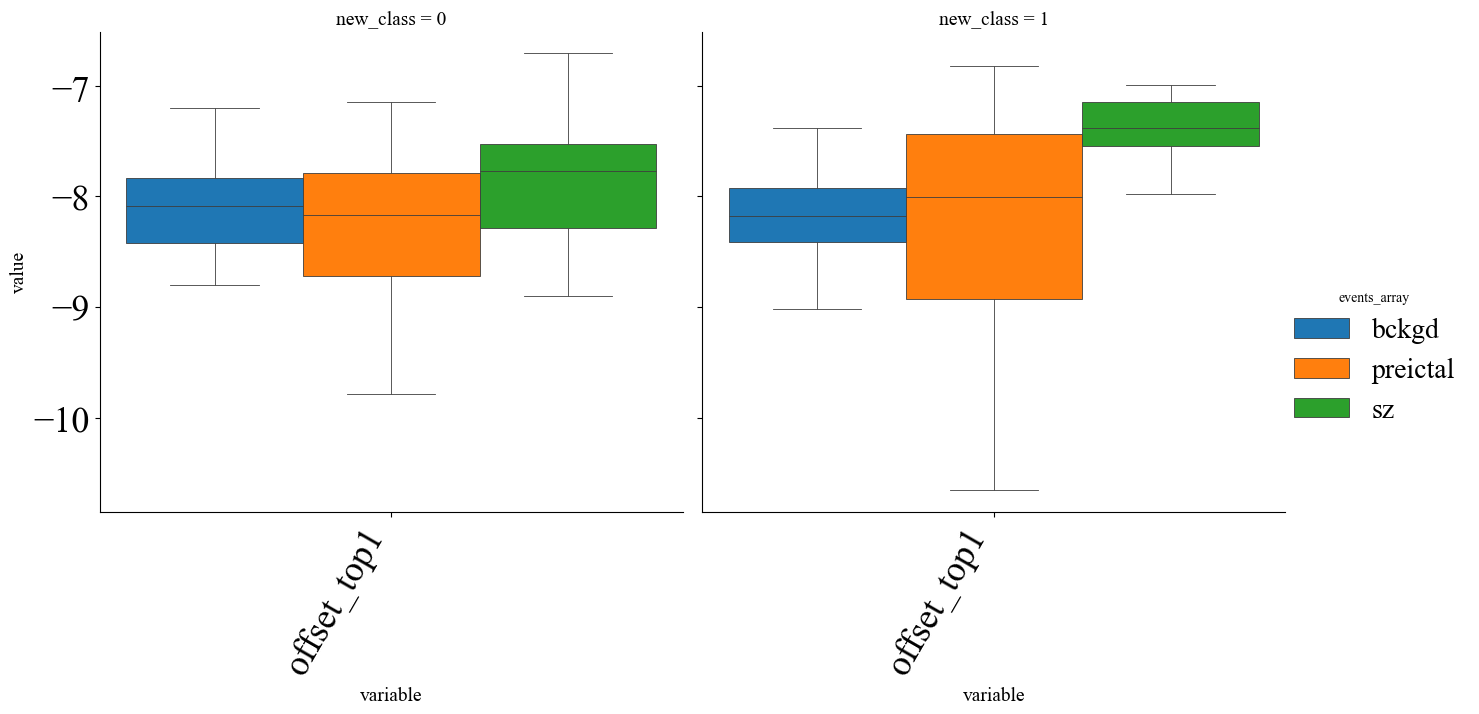

In [596]:
all_cols = wide_lobe.columns
all_features_nPCA = [c for c in all_cols if ('PCA' not in c) and ('vol' not in c)]
comparison = [c for c in all_features_nPCA if ('offset_top1' in c)]
df_long = (
    wide_lobe
    .groupby(['name', 'events_array', 'new_class'])[comparison].mean()
    .reset_index()
    .melt(
        id_vars=['events_array', 'new_class'],
        value_vars=comparison,
        var_name='variable',
        value_name='value'
    )
)
g = sns.catplot(
    data=df_long,
    kind='box',
    x='variable', y='value',
    hue='events_array',
    col='new_class',
    sharey=True, sharex=True,
    height=6, aspect=1.1,
    linewidth=0.6, saturation=1, hue_order=['bckgd', 'preictal', 'sz']
    ,showfliers=False
)

g.set_xticklabels(rotation=60, ha='right')
#g._legend.set_title('events_array')
#g.set_axis_labels("", "value")
#g.fig.subplots_adjust(top=0.85)
plt.plot()



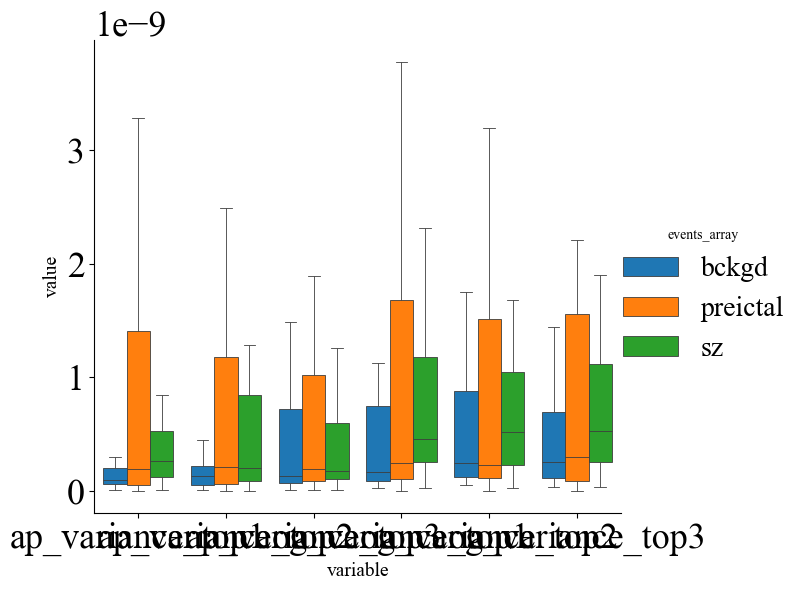

In [568]:
g = sns.catplot(
    data=df_long,
    kind='box',
    x='variable', y='value',
    hue='events_array',
    sharey=True, sharex=True,
    height=6, aspect=1.1,
    linewidth=0.6, saturation=1, hue_order=['bckgd', 'preictal', 'sz'],
    showfliers=False
)

<Axes: xlabel='variable', ylabel='value'>

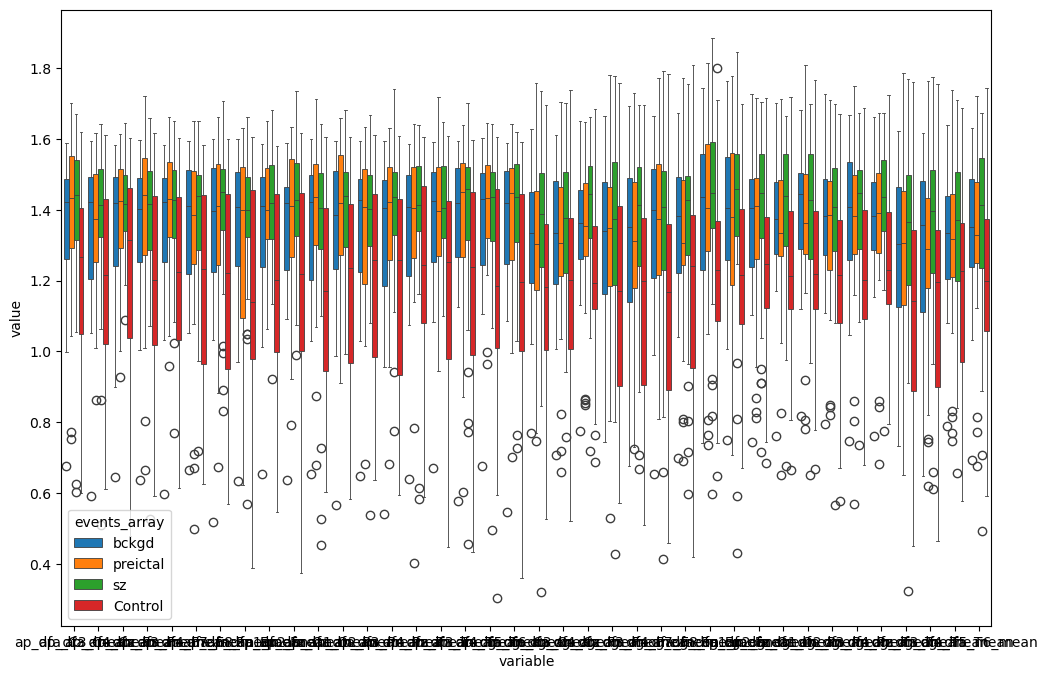

In [30]:
comparison = [c for c in all_features_nPCA if ('dfa' in c)]
df_long = wide_lobe.groupby(['name', 'events_array'])[comparison].median().reset_index().melt(
    id_vars=['events_array'], 
    value_vars=comparison,
    var_name='variable', 
    value_name='value'
)
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(
    x='variable', 
    y='value', 
    hue='events_array', 
    data=df_long, 
    linewidth=0.6, 
    saturation=1,
    ax=ax
)

In [581]:
name = '017'

In [573]:
wide_lobe[wide_lobe['name']==name]['new_class'].unique()

array([1])

'for col in comparison:\n    print(col)'

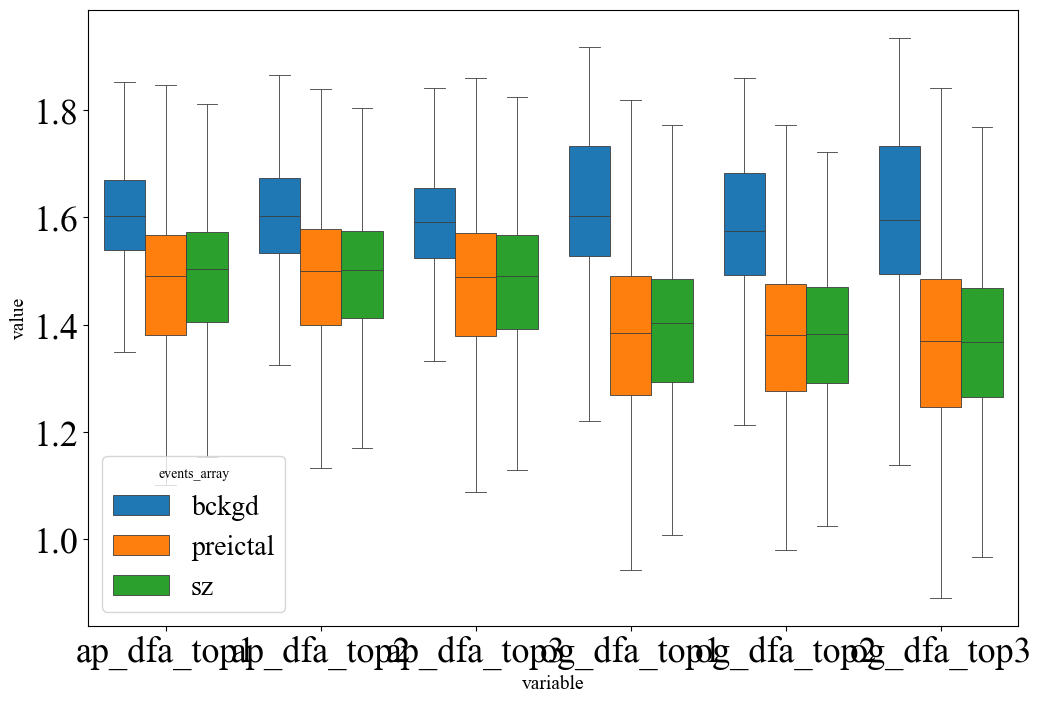

In [583]:
all_cols = wide_lobe.columns
all_features_nPCA = [c for c in all_cols if ('PCA' not in c) and ('vol' not in c)]
comparison = [c for c in all_features_nPCA if ('dfa' in c)]
df_long = wide_lobe[wide_lobe['name']==name].reset_index().melt(
    id_vars=['events_array'], 
    value_vars=comparison,
    var_name='variable', 
    value_name='value'
)
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(
    x='variable', 
    y='value', 
    hue='events_array', 
    data=df_long, 
    linewidth=0.6, 
    saturation=1,
    ax=ax,
    hue_order=['bckgd', 'preictal', 'sz'],
    showfliers=False
)
'''for col in comparison:
    print(col)'''


'for col in comparison:\n    print(col)'

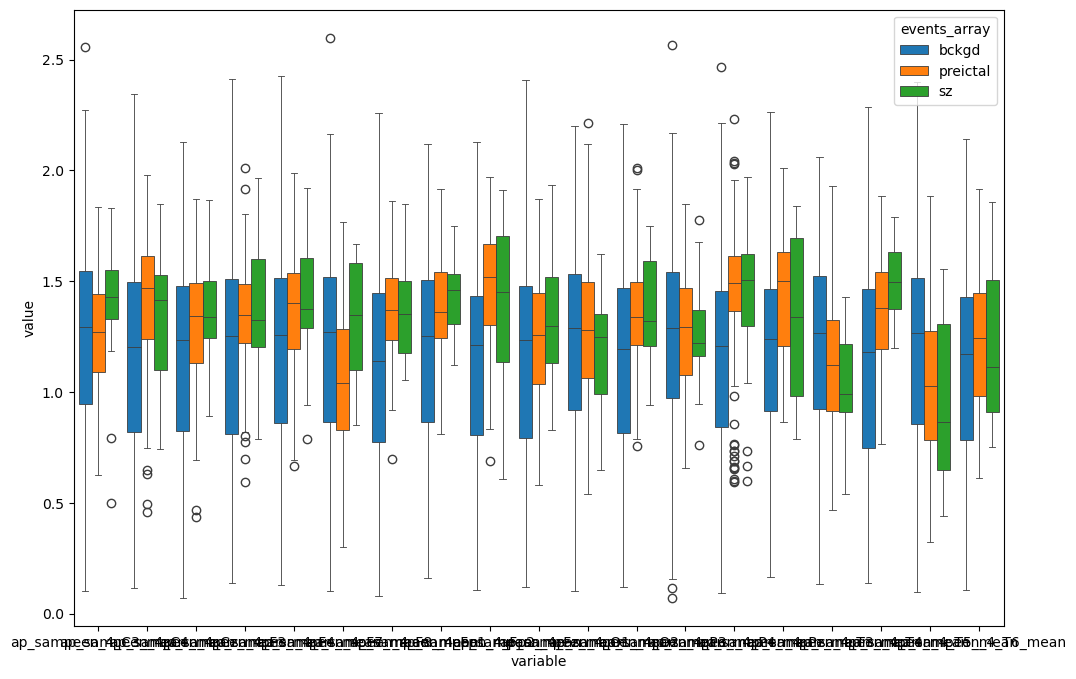

In [1124]:
all_cols = lobe.columns
all_features_nPCA = [c for c in all_cols if ('PCA' not in c) and ('vol' not in c)]
comparison = [c for c in all_features_nPCA if ('ap_sampeen_4' in c)]
df_long = lobe[lobe['name']==name].reset_index().melt(
    id_vars=['events_array'], 
    value_vars=comparison,
    var_name='variable', 
    value_name='value'
)
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(
    x='variable', 
    y='value', 
    hue='events_array', 
    data=df_long, 
    linewidth=0.6, 
    saturation=1,
    ax=ax,
    hue_order=['bckgd', 'preictal', 'sz']
)
'''for col in comparison:
    print(col)'''


- Las clases obtenidas en ML no supervisado se diferencia en la dirección del efecto. Las señales de algunos sujetos aumentan(clase 1) en complejidad y las de otros disminuyen(clase 0). Interesantemnte, los que disminuyen en complejidad aumentan en offset y al revés.

# Boxplots final

In [831]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
mpl.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 34,          # tamaño base
    "axes.titlesize": 36,
    "axes.labelsize": 14,
    "xtick.labelsize": 26,
    "ytick.labelsize": 26,
    "legend.fontsize": 30,
    "figure.titlesize": 40,
})

# ---------- helper ----------
def get_source(var):
    if var.startswith("og_"):
        return "og"
    elif var.startswith("ap_"):
        return "ap"
    else:
        return "other"
def boxplot_figure(
    wide_lobe,
    features,          # lista de strings base, ej. ['dfa', 'permen_6']
    title="", outliers = True
):
    df = wide_lobe.copy()
    # columnas relevantes (_top1 solamente)
    all_cols = df.columns
    cols = [
        c for c in all_cols
        for f in features
        if c.endswith("_top1") and f in c
    ]
    df['new_class'] = df['new_class'].map({
        0: 'Clase 0',
        1: 'Clase 1'
    })
    df['events_array'] = df['events_array'].map({
        'bckgd': 'Reposo',
        'preictal': 'Preictal',
        'sz': 'Sz'
    })
    
    print(df['events_array'].unique())

    '''dfa = [c for c in all_features_nPCA if ('dfa' in c)]
    wide_lobe[dfa] = wide_lobe[dfa] - 1'''
    #df[cols].columns = df[cols].columns.str[3:]
    # pasar a long
    df_long = (
        df
        .groupby(['name', 'events_array', 'new_class'])[cols]
        .mean()
        .reset_index()
        .melt(
            id_vars=['events_array', 'new_class'],
            value_vars=cols,
            var_name='variable',
            value_name='value'
        )
    )

    # OG / AP
    df_long['source'] = df_long['variable'].apply(get_source)

    # nombre base (sin og_/ap_ y sin _top1)
    df_long['feature'] = (
        df_long['variable']
        .str.replace(r"^(og_|ap_)", "", regex=True)
        .str.replace(r"_top1$", "", regex=True)
    )
    # ---------- plotting ----------
    n_feat = len(features)
    fig, axes = plt.subplots(
        nrows=n_feat,
        ncols=len(df_long['new_class'].unique()),
        figsize=(8 * len(df_long['new_class'].unique()), 6 * n_feat),
        sharey="row"
    )

    if n_feat == 1:
        axes = axes[None, :]

    for i, f in enumerate(features):
        df_f = df_long[df_long['feature'].str.contains(f)]

        for j, cls in enumerate(sorted(df_f['new_class'].unique())):
            ax = axes[i, j]

            sns.boxplot(
                data=df_f[df_f['new_class'] == cls],
                x='source',                 # og / ap
                y='value',
                hue='events_array',         
                hue_order=['Reposo', 'Preictal', 'Sz'],
                showfliers=outliers,
                linewidth=0.7,
                ax=ax,
                palette=palette
            )
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)


            if i == 0:
                ax.set_title(cls)

            if j > 0:
                ax.set_ylabel("")

            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.set_xticklabels(['AP', 'OG'])

            # título de fila
            if j == 0:
                ax.annotate(
                    pretty_name(f + "_top1")[3:],
                    xy=(-0.15, 0.5),
                    xycoords='axes fraction',
                    rotation=90,
                    va='center',
                    ha='right'
                )

            if i > -1:
                ax.get_legend().remove()

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc='upper center',
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.55, .98)
    )

    fig.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()




In [858]:
palette = ["#4CAF50", "#FFC107", "#F44336"]
palette = ['#B0B0B0', "#FFC107", "#F44336"]

palette = ["#FFF8E1",  # amarillo muy claro (reposo)
 "#FFB300",  # ámbar (preictal)
 "#E65100"]  # naranja oscuro (sz)
  # café oscuro (sz)
["#BBDEFB", "#64B5F6", "#0D47A1"]





['#BBDEFB', '#64B5F6', '#0D47A1']

['Sz' 'Preictal' 'Reposo']


/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_15826/1952966925.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['AP', 'OG'])
/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_15826/1952966925.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['AP', 'OG'])
/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_15826/1952966925.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['AP', 'OG'])
/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_15826/1952966925.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['AP', 'OG'])
/var/folders

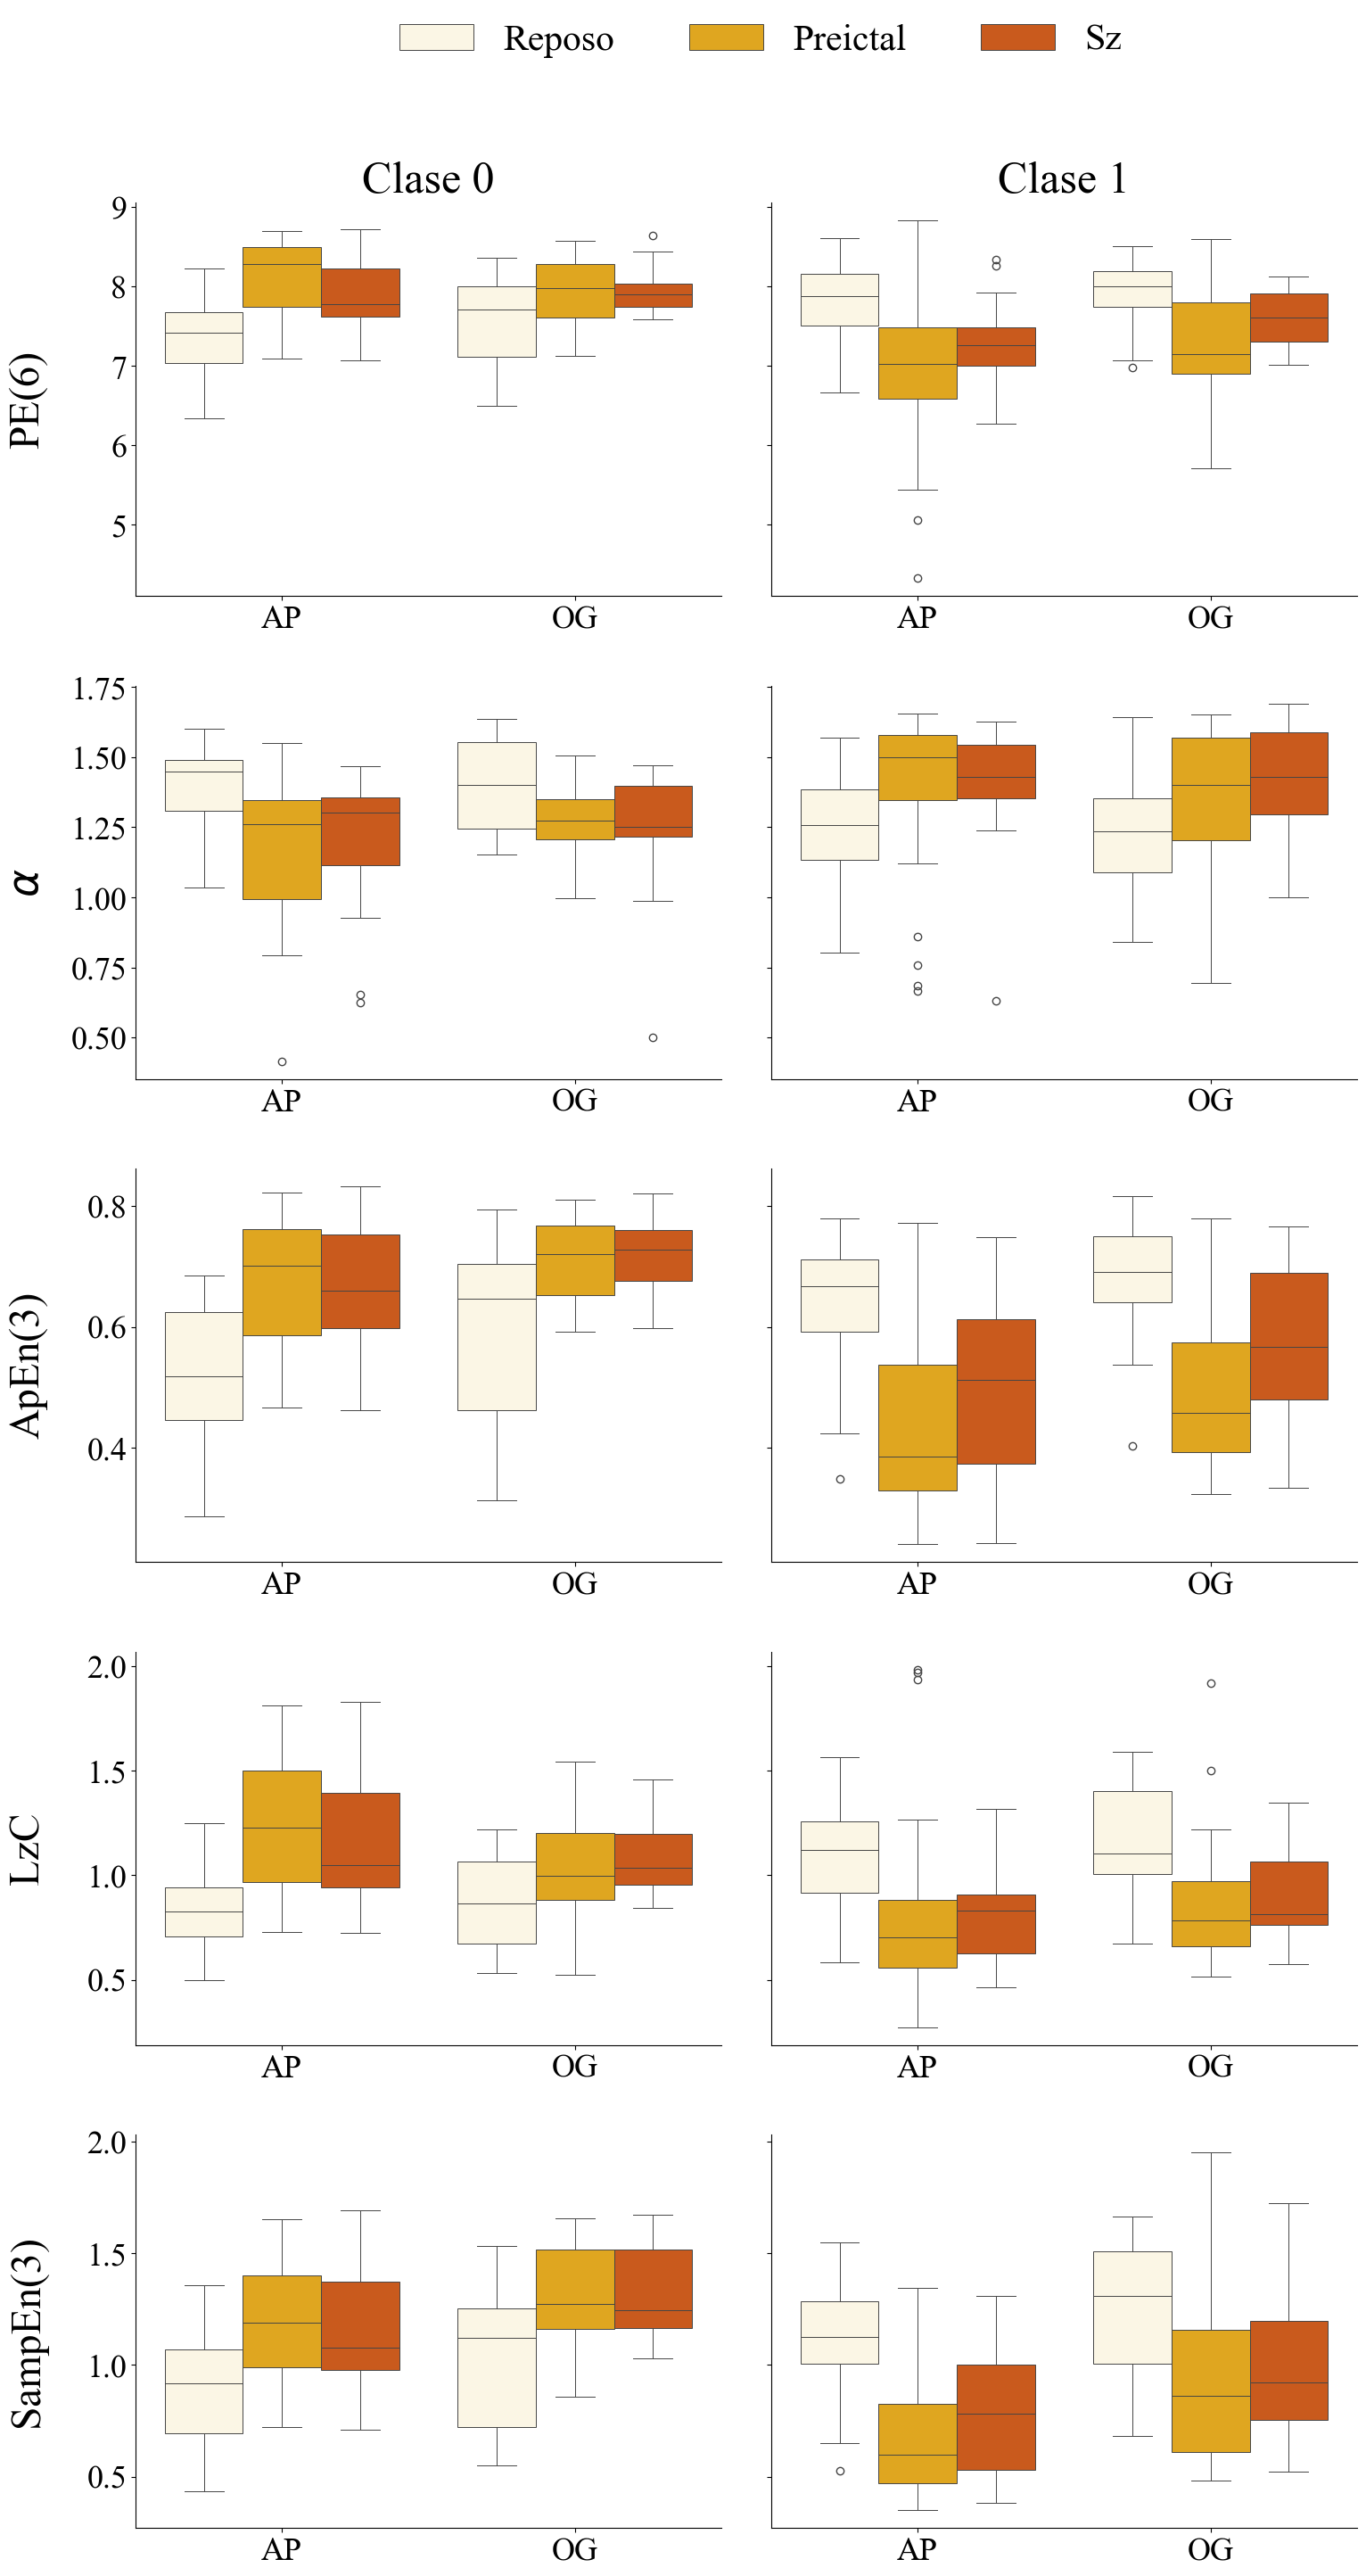

In [859]:
features_complexity = [
    'permen_6',
    'dfa',
    'aproxen_3',
    'lz_complexity',
    'sampeen_3'
]

boxplot_figure(
    wide_lobe,
    features_complexity, outliers = True
)

['Sz' 'Preictal' 'Reposo']


/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_15826/1952966925.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['AP', 'OG'])
/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_15826/1952966925.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['AP', 'OG'])
/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_15826/1952966925.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['AP', 'OG'])
/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_15826/1952966925.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['AP', 'OG'])
/var/folders

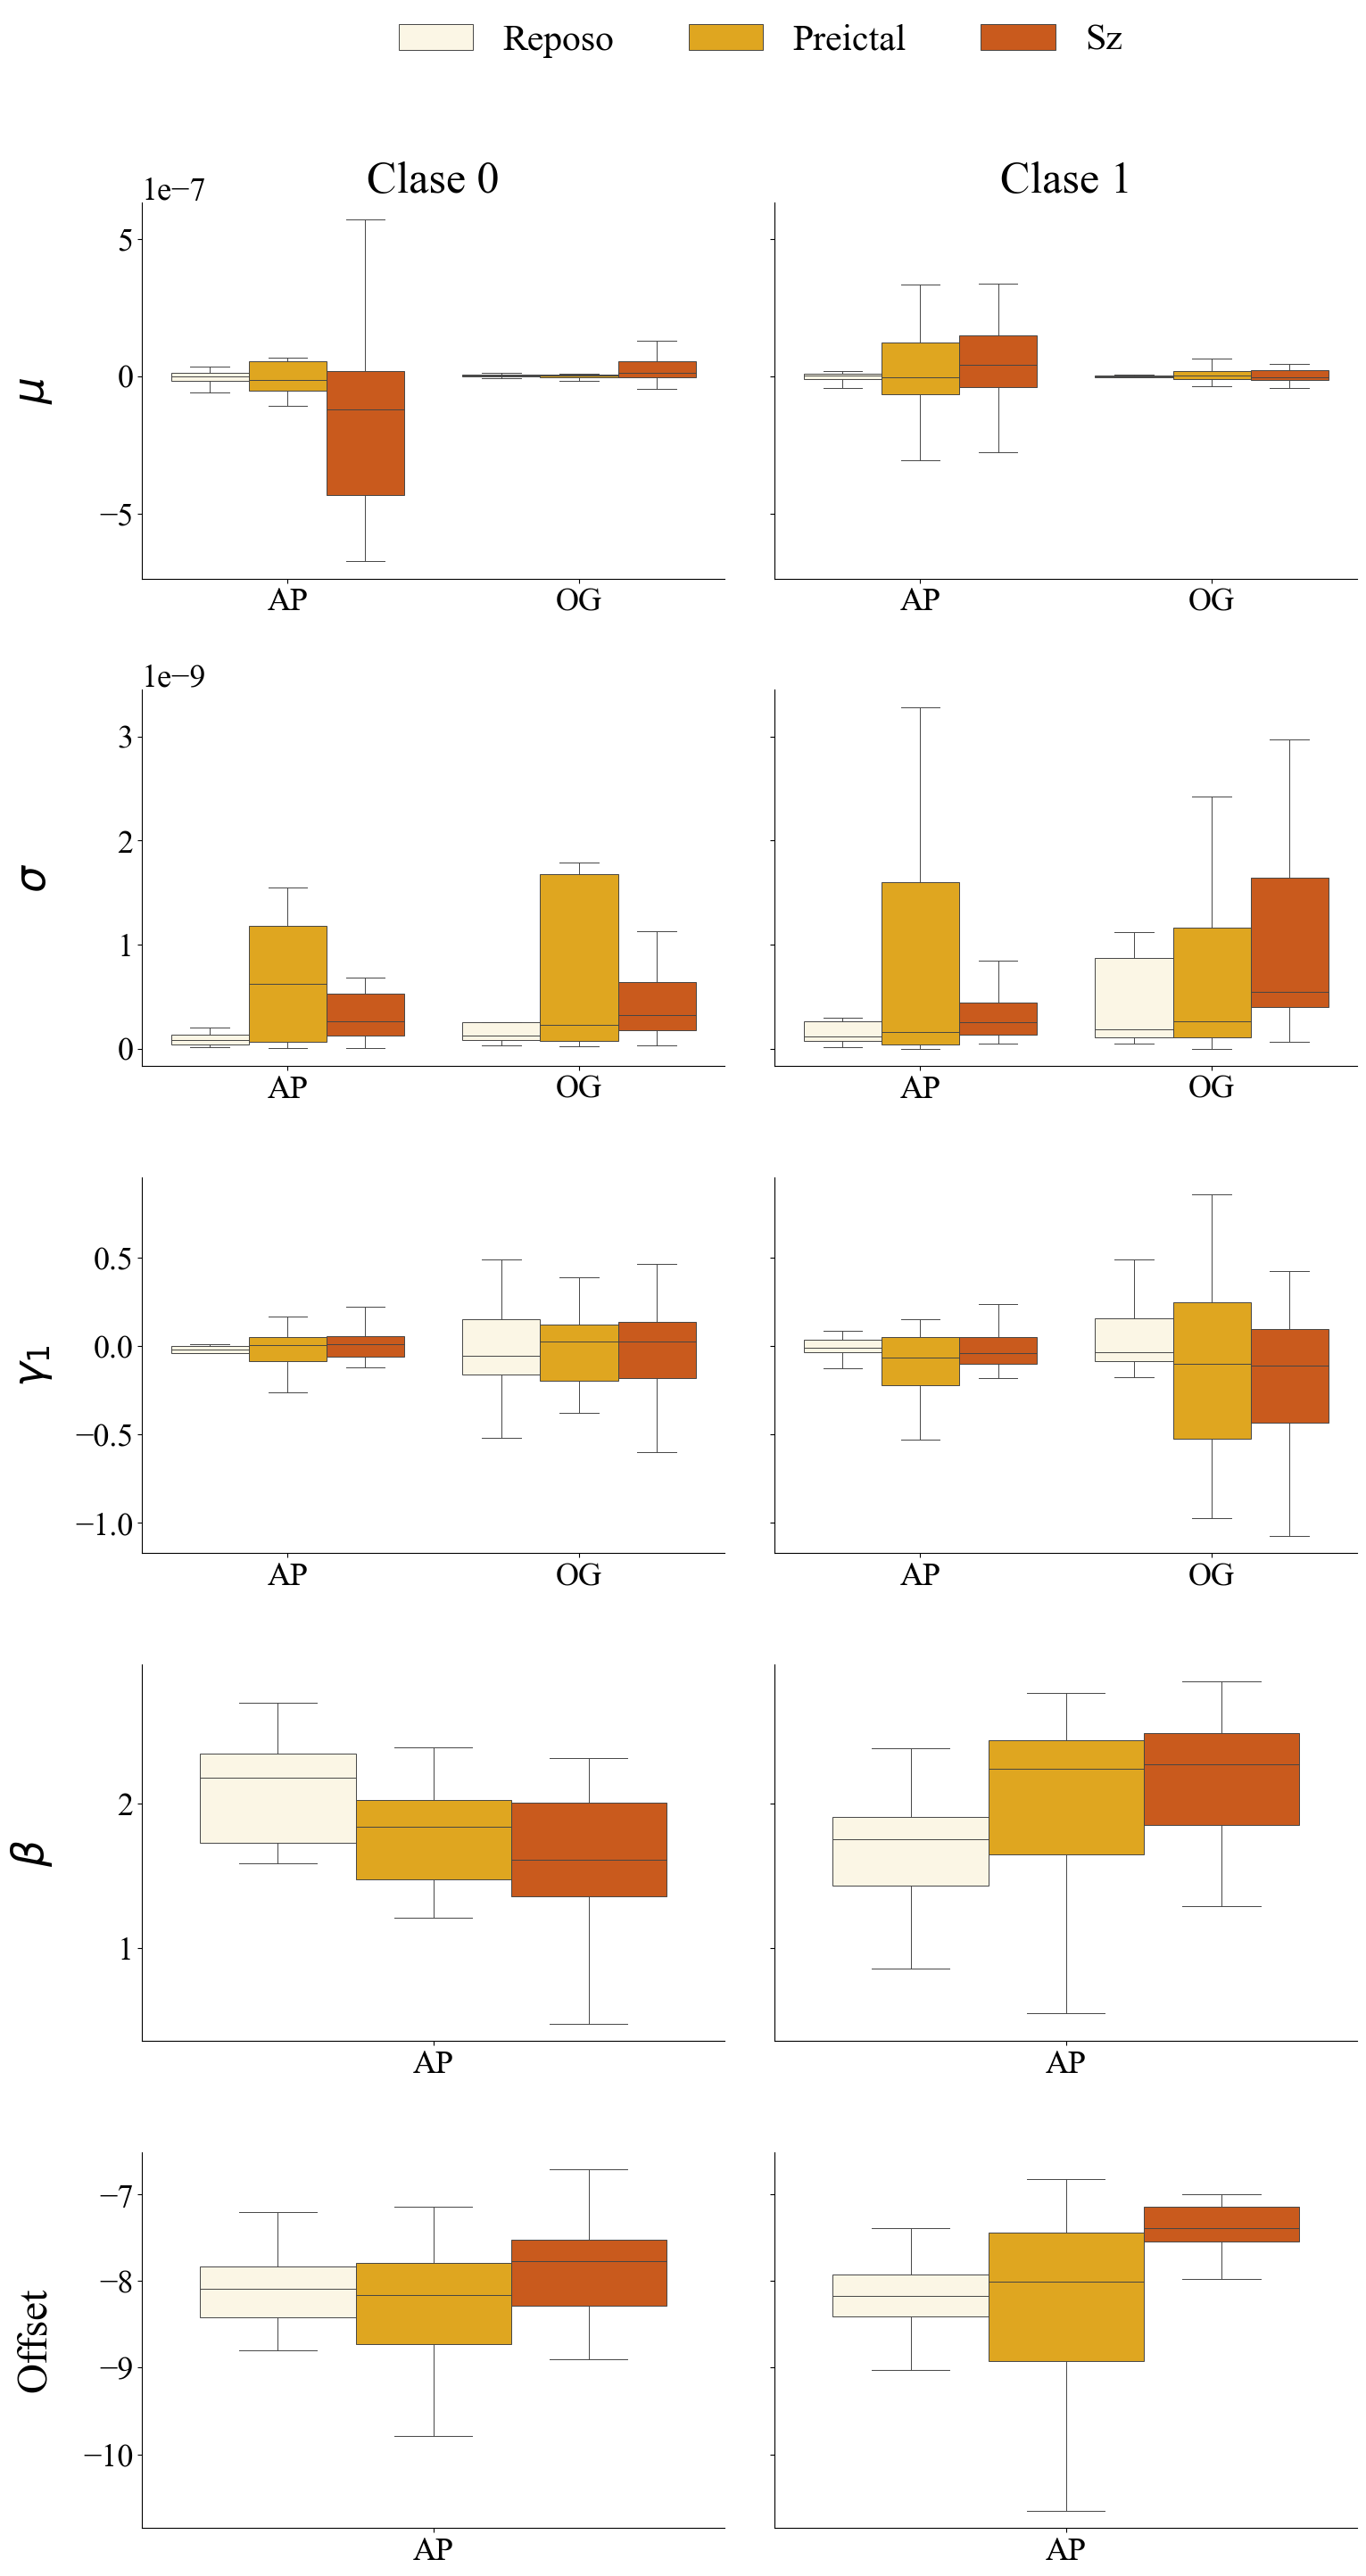

In [860]:
features_complexity = [
    'mean_value',
    'variance',
    'skewness',
    'exponent',
    'offset'
]

boxplot_figure(
    wide_lobe,
    features_complexity, outliers = False
)

# Heatmap class

In [733]:
wide_top = pd.read_pickle('wide_topk3.pkl')
wide_lobe = procesamiento(wide_top)

In [77]:
# z_score
info_cols = ['events_array', 'name', 'session_run', 'time']
all_features = wide_lobe.columns
all_features = [f for f in all_features if not 'PCA' in f]
#all_features.remove('offset')
all_features.remove('new_class')
all_features = list(set(all_features) - set(info_cols))

subject_no_baseline = []

for subject in wide_lobe.name.unique():

    subject_mask = wide_lobe['name'] == subject
    try:
        baseline_mask = wide_lobe['events_array'] == 'bckgd'
        scaler = StandardScaler()
        scaler.fit(wide_lobe[(subject_mask) & (baseline_mask)][all_features])
        wide_lobe.loc[(subject_mask), all_features] = scaler.transform(wide_lobe[(subject_mask)][all_features])
        
    except:
        subject_no_baseline.append(subject)

subjects_to_drop = set(subject_no_baseline)
wide_lobe = wide_lobe[~wide_lobe['name'].isin(subjects_to_drop)]

In [783]:
pat = r'(ap_aproxen_3|dfa|lz_complexity|ap_permen_6|ap_sampeen_3|exponent|offset|og_aproxen_3|og_permen_6|og_sampeen_3|variance|mean|skewness)'
pvals1, effects1, auc = mwu_with_sign(
    wide_lobe[wide_lobe['new_class']==1],
    id_col='name',
    cond_col='events_array',
    info_cols=['events_array','name','session_run','time'],
    aggregate='mean',         
    effect='median_diff'    
)
mask = pvals1.index.to_series().astype(str).str.contains(pat, regex=True)
pvals1 = pvals1[mask]

pvals0, effects2, auc = mwu_with_sign(
    wide_lobe[wide_lobe['new_class']==0],
    id_col='name',
    cond_col='events_array',
    info_cols=['events_array','name','session_run','time'],
    aggregate='mean',         
    effect='median_diff'    
)
mask = pvals0.index.to_series().astype(str).str.contains(pat, regex=True)
pvals0 = pvals0[mask]

new_class
SKIP: todas las diferencias son 0
SKIP: muy pocos pares informativos
new_class
SKIP: todas las diferencias son 0
SKIP: muy pocos pares informativos
new_class
SKIP: todas las diferencias son 0
SKIP: muy pocos pares informativos


/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_15826/3769212769.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = pvals1.index.to_series().astype(str).str.contains(pat, regex=True)


ap_variance_top2
SKIP: todas las diferencias son 0
ap_variance_top3
SKIP: todas las diferencias son 0
new_class
SKIP: todas las diferencias son 0
SKIP: muy pocos pares informativos
new_class
SKIP: todas las diferencias son 0
SKIP: muy pocos pares informativos
new_class
SKIP: todas las diferencias son 0
SKIP: muy pocos pares informativos
og_variance_top2
SKIP: todas las diferencias son 0
og_variance_top3
SKIP: todas las diferencias son 0


/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_15826/3769212769.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = pvals0.index.to_series().astype(str).str.contains(pat, regex=True)


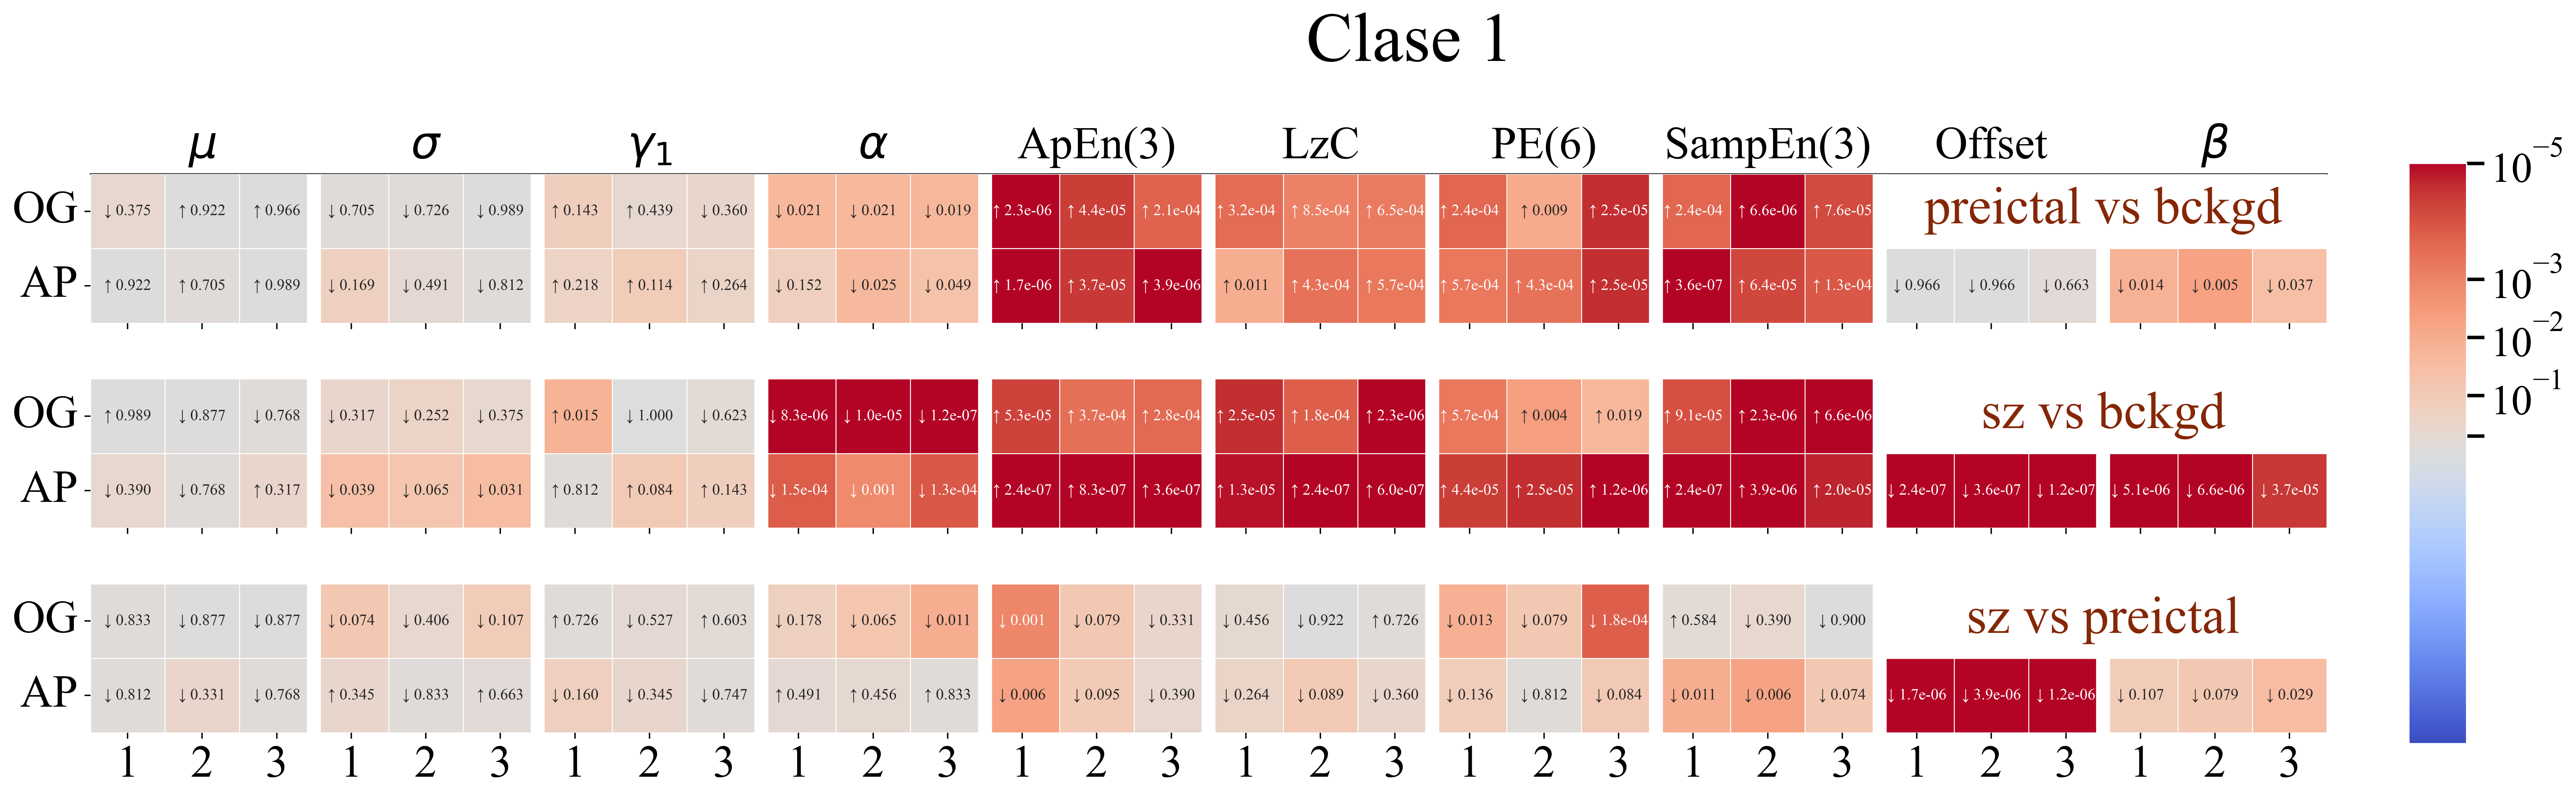

In [784]:
heatmap_mwu(effects1, pvals1, title="Clase 1")

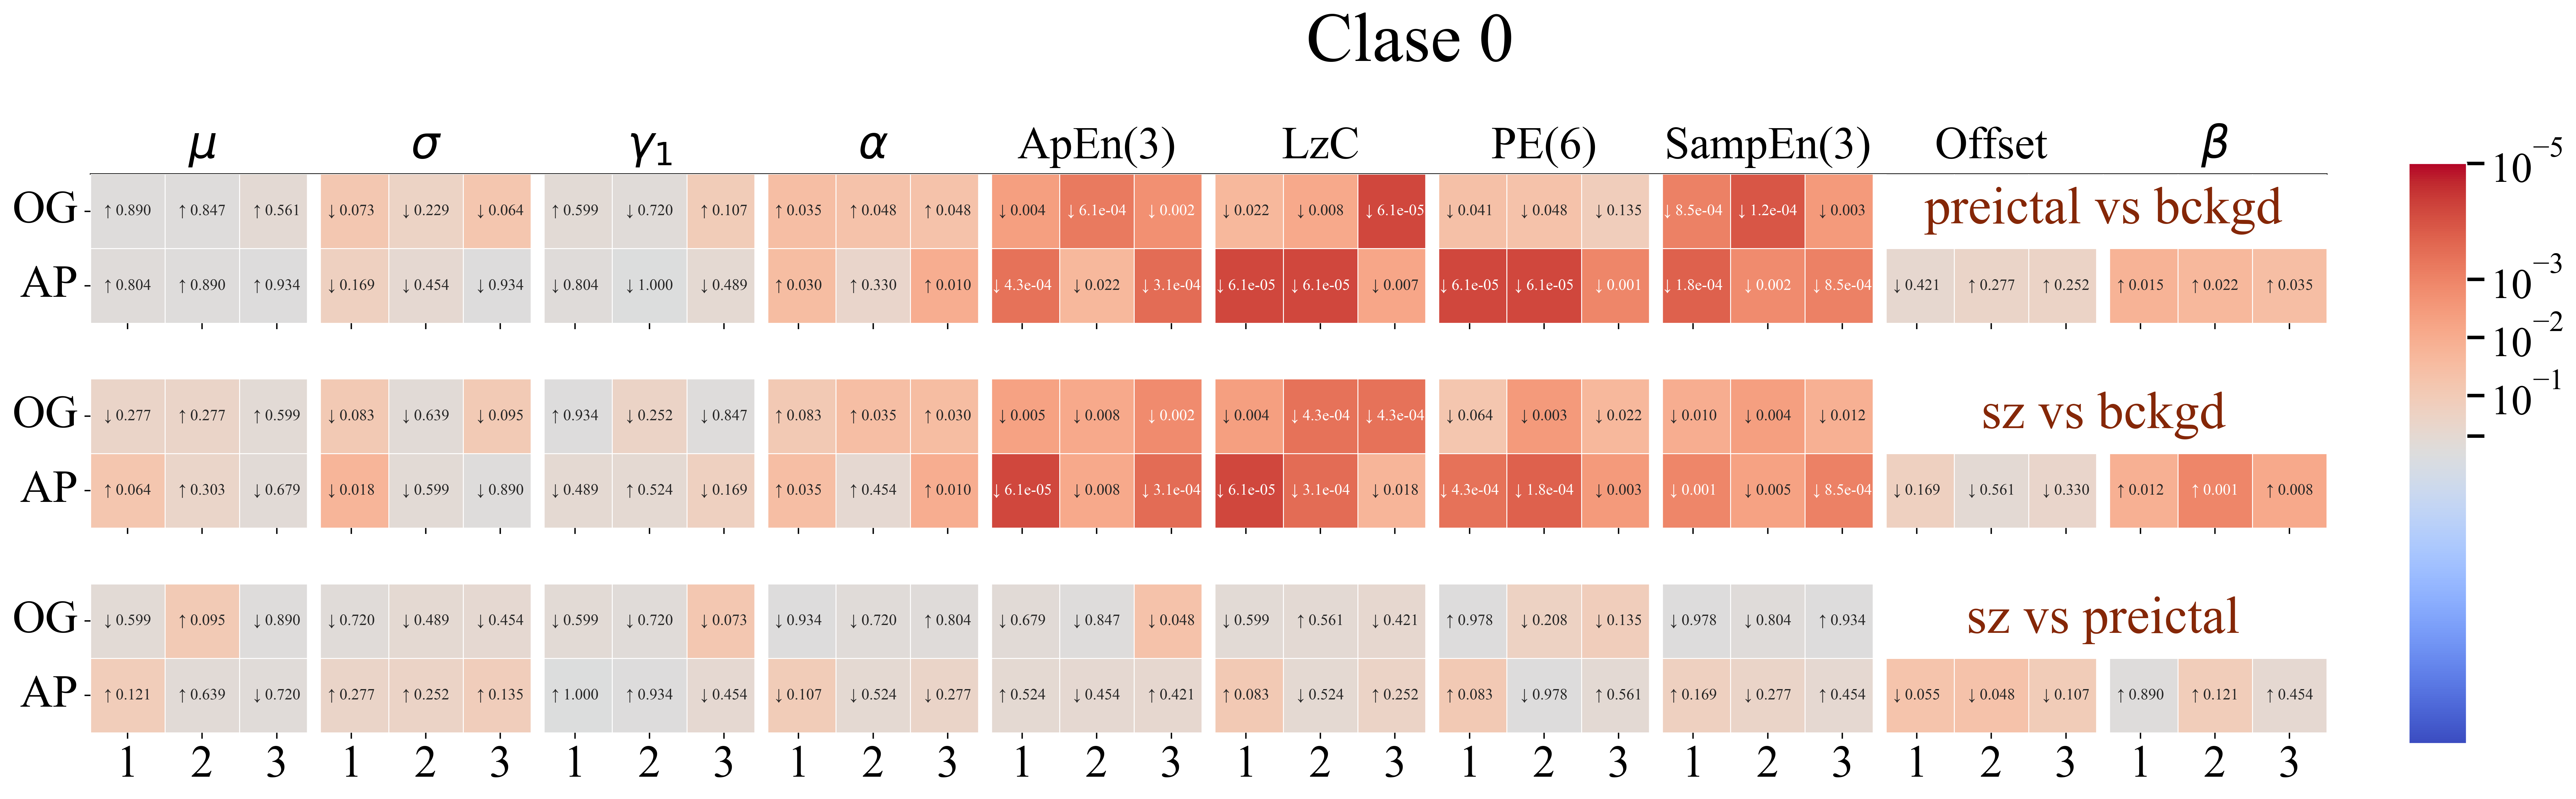

In [785]:
heatmap_mwu(effects2, pvals0, title="Clase 0")

In [15]:
wide_lobe.drop(columns='index', inplace=True)

/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_49466/1169006232.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = pvals3.index.to_series().astype(str).str.contains(pat, regex=True)


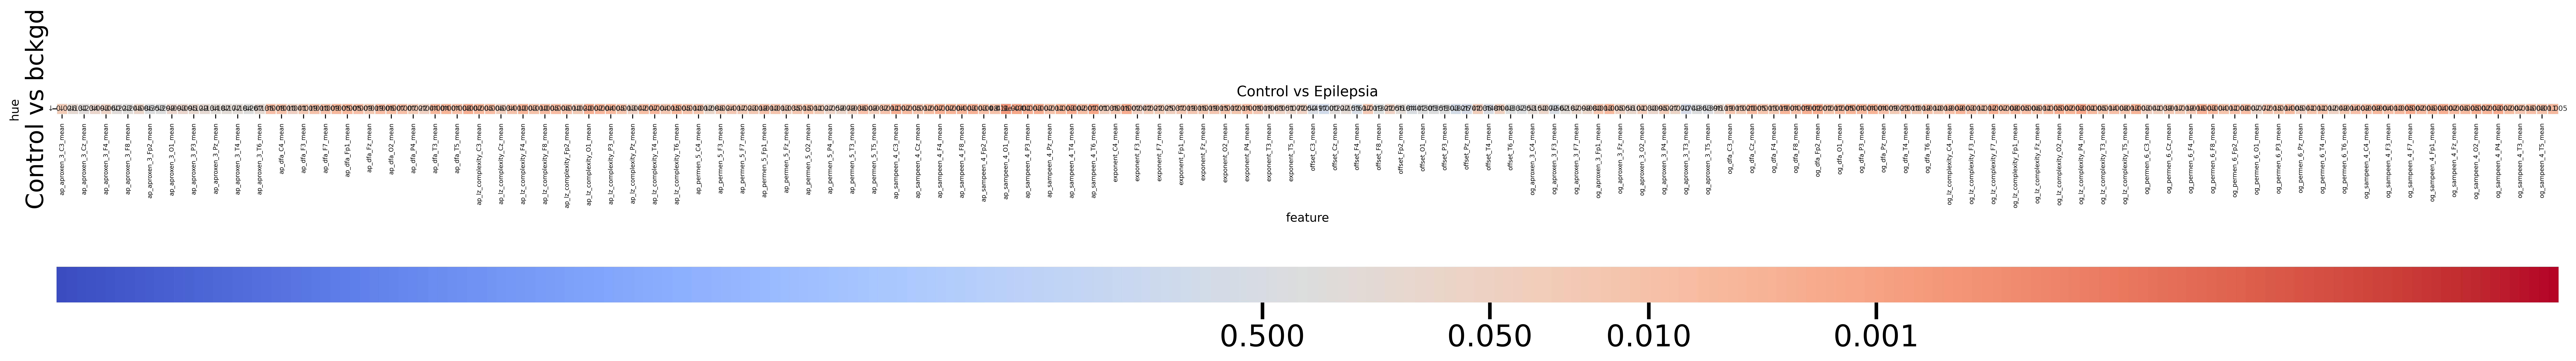

In [23]:
# Electrodo por electrodo
pat = r'(ap_aproxen_3|dfa|lz_complexity|ap_permen_5|ap_sampeen_4|exponent|offset|og_aproxen_3|og_permen_6|og_sampeen_4)'
#lobe.drop(columns=[c for c in lobe.columns if 'permen_6' in c], inplace=True)
pvals3, effect3, auc = mwu_with_sign(
    wide_lobe[wide_lobe['events_array'].isin(['Control', 'bckgd'])],
    id_col='name',
    cond_col='events_array',
    info_cols=['events_array','name','session_run','time', 'new_class'],
    aggregate='median',         
    effect='median_diff'    
)
mask = pvals3.index.to_series().astype(str).str.contains(pat, regex=True)
pvals3 = pvals3[mask]
heatmap_mwu(effect3, pvals3, title="Control vs Epilepsia")

In [31]:
# Media por técnica
import pandas as pd
import numpy as np
import re

def average_electrodes_per_tech(df, info_cols=None, suffix='_mean_all'):
    if info_cols is None:
        info_cols = []

    # columnas de features
    feature_cols = [c for c in df.columns if c not in info_cols]

    tech_to_cols = {}

    for col in feature_cols:
        parts = col.split('_')
        if len(parts) < 3:
            continue
        if parts[-1] != 'mean':
            continue

        tech = '_'.join(parts[:-2])   # ap_aproxen_2
        tech_to_cols.setdefault(tech, []).append(col)

    # nuevo DF con solo info
    out = df[info_cols].copy()

    # para cada técnica, promediar por fila sus columnas
    for tech, cols in tech_to_cols.items():
        new_col = f"{tech}{suffix}"
        out[new_col] = df[cols].median(axis=1)

    return out

info_cols = ['name', 'session_run', 'events_array', 'time', 'new_class']
wide_lobe_mean_tech = average_electrodes_per_tech(lobe, info_cols=info_cols, suffix='_mediana')
pat = r'(ap_aproxen_3|dfa|lz_complexity|ap_permen_5|ap_sampeen_4|exponent|offset|og_aproxen_3|og_permen_6|og_sampeen_4)'
#lobe.drop(columns=[c for c in lobe.columns if 'permen_6' in c], inplace=True)
pvals3, effect3, auc = mwu_with_sign(
    wide_lobe_mean_tech[wide_lobe_mean_tech['events_array'].isin(['Control', 'bckgd'])],
    id_col='name',
    cond_col='events_array',
    info_cols=['events_array','name','session_run','time', 'new_class'],
    aggregate='median',         
    effect='median_diff'    
)
mask = pvals3.index.to_series().astype(str).str.contains(pat, regex=True)
pvals3 = pvals3[mask]

/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_49466/1053355149.py:47: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = pvals3.index.to_series().astype(str).str.contains(pat, regex=True)


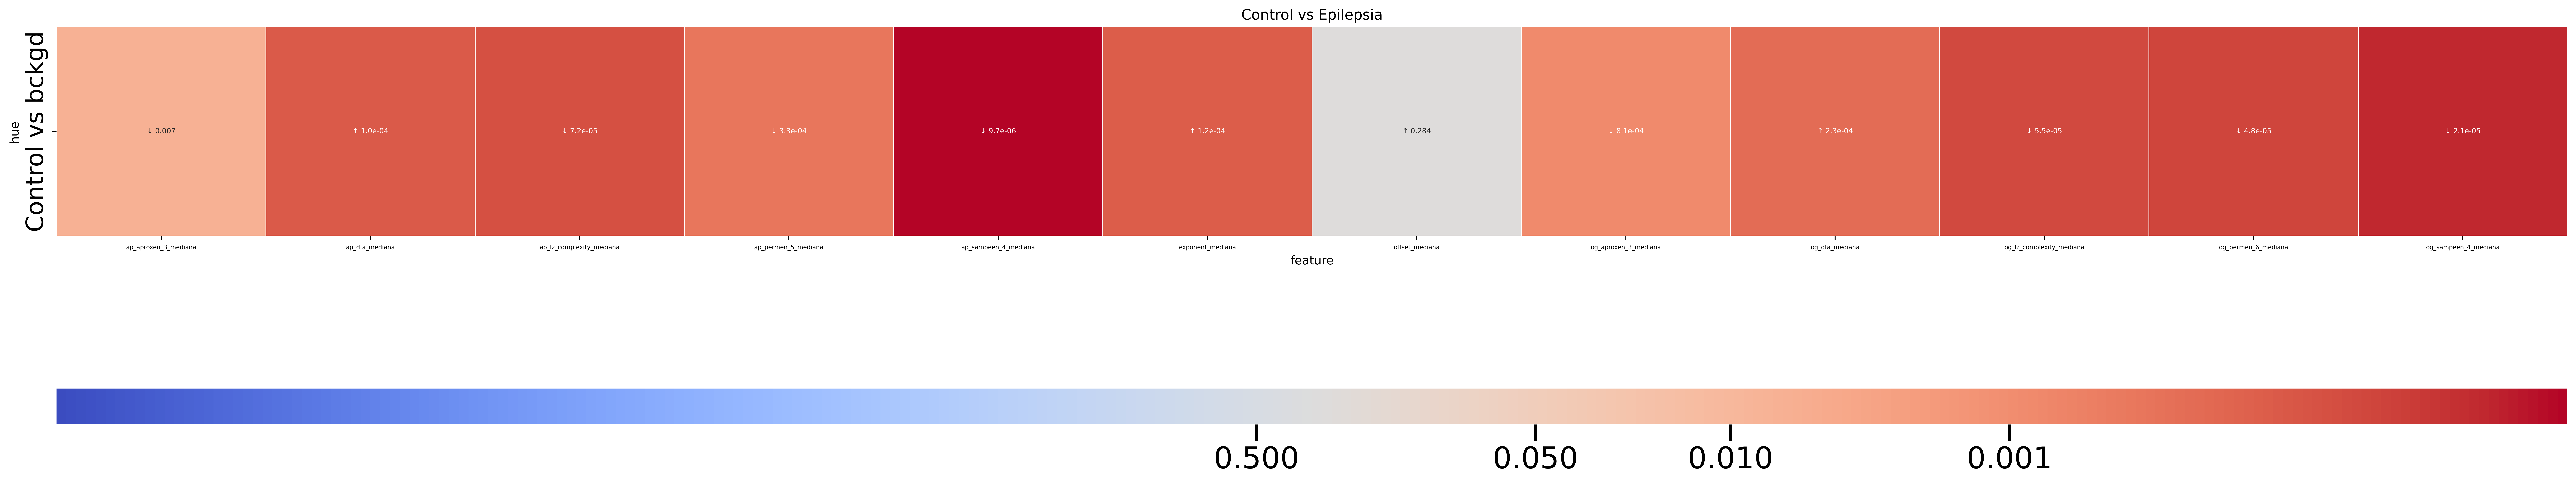

In [32]:
heatmap_mwu(effect3, pvals3, title="Control vs Epilepsia")


# Heatmap no class

In [584]:
pat = r'(ap_aproxen_3|dfa|lz_complexity|ap_permen_6|ap_sampeen_3|exponent|offset|og_aproxen_3|og_permen_6|og_sampeen_3|variance|mean|skewness)'
pvals1, effects1, auc = mwu_with_sign(
    wide_lobe,
    id_col='name',
    cond_col='events_array',
    info_cols=['events_array','name','session_run','time'],
    aggregate='mean',         
    effect='median_diff'    
)
mask = pvals1.index.to_series().astype(str).str.contains(pat, regex=True)
pvals1 = pvals1[mask]

new_class
SKIP: todas las diferencias son 0
SKIP: muy pocos pares informativos
new_class
SKIP: todas las diferencias son 0
SKIP: muy pocos pares informativos
new_class
SKIP: todas las diferencias son 0
SKIP: muy pocos pares informativos


/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_15826/3528660398.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = pvals1.index.to_series().astype(str).str.contains(pat, regex=True)


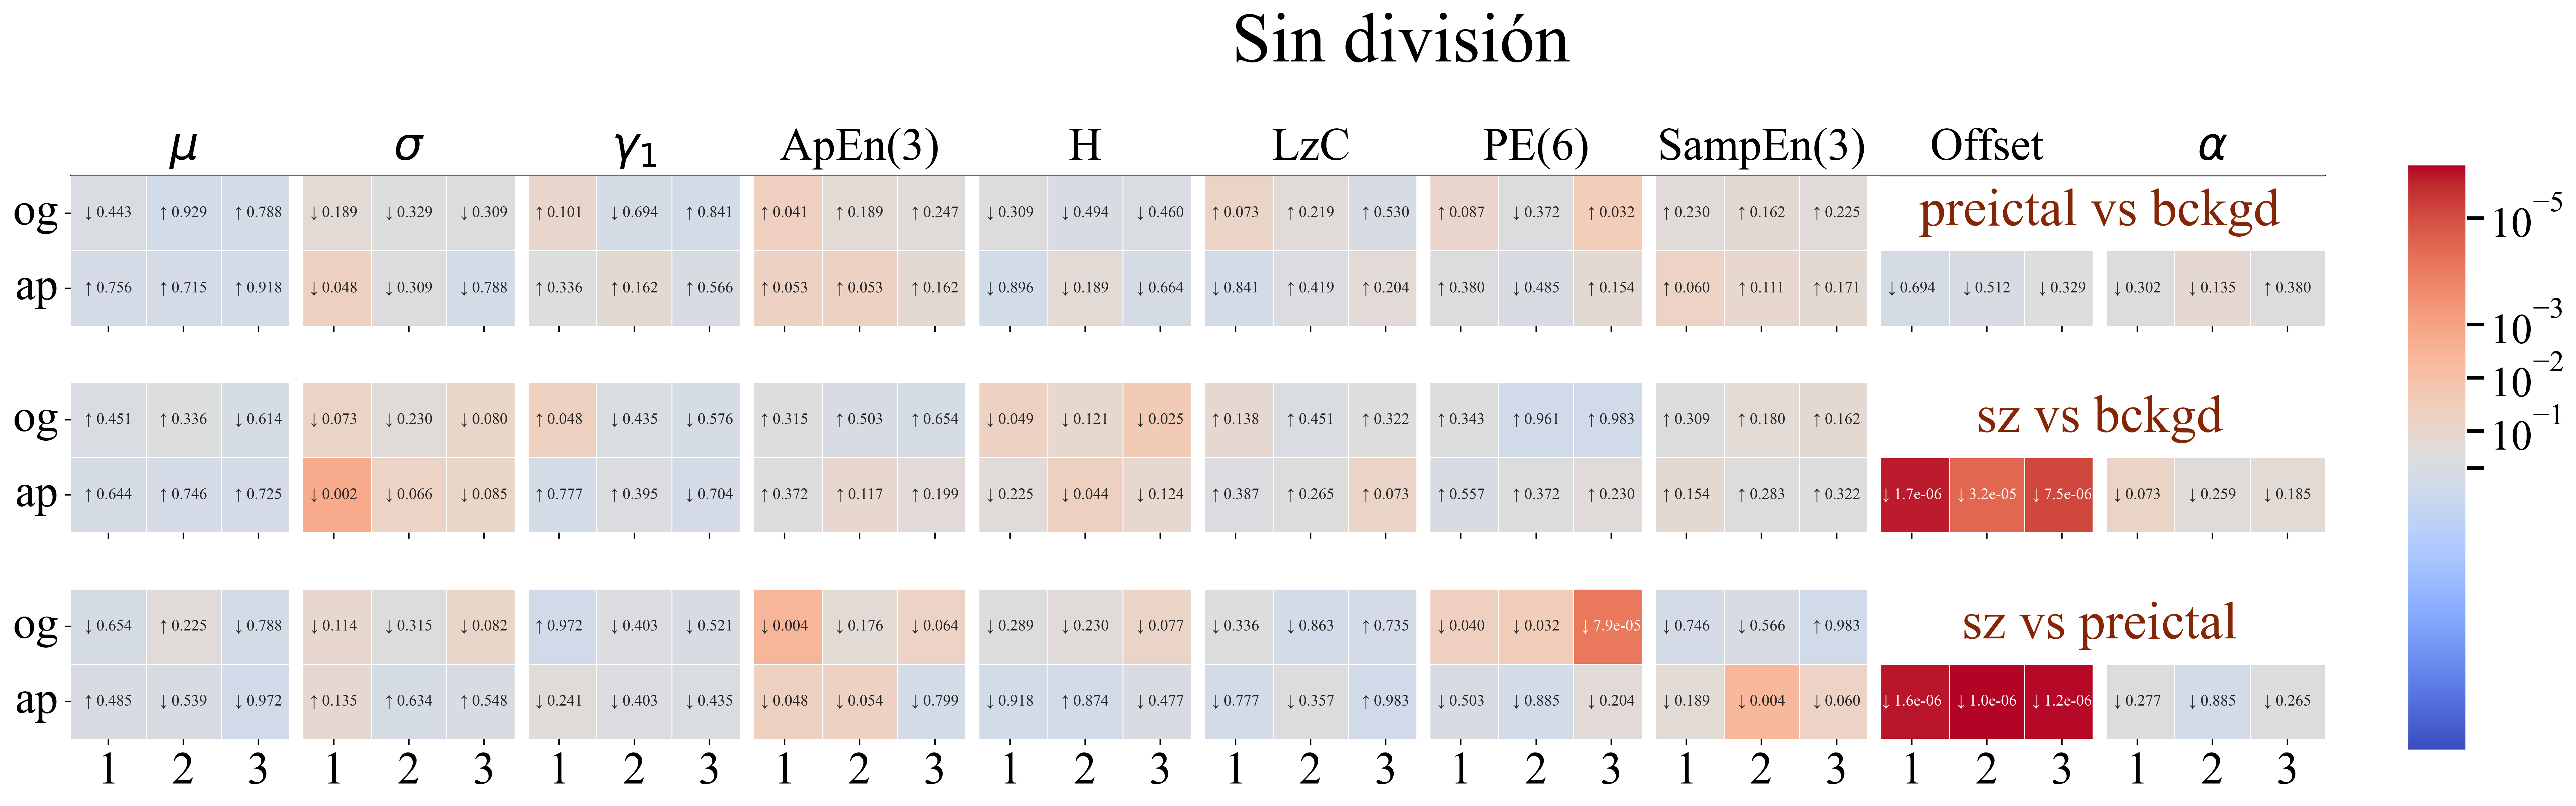

In [586]:
heatmap_mwu(effects1, pvals1, title="Sin división")

# Top3 electrodos 

 - t test no funciona muy bien despues del zscore. no hay buen gradiente top
 - auroc parece funcionar bine con el gradiente top
 - info mutua también funciona bien, pero no reporta tanta significacncia como en auc. detecta otros patrones cuando se hace un top 3 ap y og
 - las diferencias entre auroc e infomutua con top3 ap/og demuestran que no todas las técnicas sobresalen con los mismo electrodos
 
 Por eso decidí hacer top 3 por cada tecnica cona auroc

In [1]:
import pandas as pd
wide_lobe = pd.read_pickle('wide_electrode_250_6.pkl')

KeyboardInterrupt: 

In [7]:
all_cols = wide_lobe.columns
all_features_nPCA = [c for c in all_cols if ('PCA' not in c) and ('vol' not in c)]
#PCA_cols = [c for c in all_cols if ('PCA' in c) and (('_1_' in c)) or (('_2_' in c)) or (('_3_' in c))]
#all_features_nPCA += PCA_cols
wide_lobe = wide_lobe[all_features_nPCA]
wide_lobe=procesamiento(wide_lobe)
wide_lobe.drop(index=wide_lobe[wide_lobe['events_array'].isin(['close_preictal', 'postictal', 'interictal'])].index, inplace=True)
wide_lobe.groupby(['new_class'])['name'].nunique()

new_class
0    15
1    24
Name: name, dtype: int64

In [22]:
print(wide_lobe.dropna()['events_array'].value_counts())

events_array
bckgd       47090
sz          30488
preictal    28891
Name: count, dtype: int64


 - Se remueven sujetos y por eso hay menos events

- ROC AUC es el que mejor sirve

In [115]:
'''Prueba estadisticas'''
from itertools import combinations
from scipy.stats import mannwhitneyu, ttest_ind, wilcoxon 

def mwu_per_subject(df,
                    id_col='name',
                    cond_col='events_array',
                    info_cols=('events_array','name','session_run','time'),
                    effect='median_diff'):   # 'cliffs' | 'median_diff'

    all_features = sorted(list(set(df.columns) - set(info_cols)))
    rows = []

    for subj, sub in df.groupby(id_col):
        print(subj)
        cond_vals = sub[cond_col].unique()
        # sólo seguimos si el sujeto tiene ambas condiciones
        if not ({'bckgd','preictal'} <= set(cond_vals)):
            continue

        for feat in all_features:
            x = sub[sub[cond_col] == 'bckgd'][feat].dropna().values
            y = sub[sub[cond_col] == 'preictal'][feat].dropna().values

            # necesitamos al menos 1 dato en cada lado
            if (len(x) == 0) or (len(y) == 0):
                continue

            #res = mannwhitneyu(x, y, alternative='two-sided')
            res = ttest_ind(x, y, alternative='two-sided')
            #res = wilcoxon(x, y, alternative='two-sided')
            p = res.pvalue
            U = res.statistic
            nA, nB = len(x), len(y)
            auc = U / (nA * nB)
            cliffs = 2*auc - 1

            if effect == 'cliffs':
                eff = cliffs
            elif effect == 'median_diff':
                eff = 1 if np.median(y) > np.median(x) else -1
            else:
                raise ValueError("effect debe ser 'cliffs' o 'median_diff'.")

            rows.append({
                id_col: subj,
                'feature': feat,
                'hue': 'bckgd vs preictal',
                'p': p,
                'effect': eff,
                'auc': auc
            })

    out = pd.DataFrame(rows)
    return out


In [35]:
'''Información mutua'''
from itertools import combinations
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

def mwu_per_subject(df,
                   id_col='name',
                   cond_col='events_array',
                   info_cols=('events_array','name','session_run','time'),
                   effect='median_diff',    # por ahora sólo 'median_diff'
                   n_neighbors=3,
                   random_state=42):
    """
    Compara preictal vs bckgd DENTRO de cada sujeto usando información mutua.
    
    Devuelve un DataFrame con columnas:
        name, feature, hue, p, effect, mi

    - 'mi' es la información mutua entre el valor de la feature y la condición
      (bckgd vs preictal) en ese sujeto.
    - 'effect' es:
        * 'median_diff': mediana(preictal) - mediana(bckgd)
    - 'p' se deja como NaN (no hay test de hipótesis clásico asociado).
    """
    all_features = sorted(list(set(df.columns) - set(info_cols)))
    rows = []

    for subj, sub in df.groupby(id_col):
        print(subj)
        cond_vals = sub[cond_col].unique()

        # sólo seguimos si el sujeto tiene ambas condiciones
        if not ({'bckgd', 'preictal'} <= set(cond_vals)):
            continue

        for feat in all_features:
            x = sub[sub[cond_col] == 'bckgd'][feat].dropna().values
            y = sub[sub[cond_col] == 'preictal'][feat].dropna().values

            # necesitamos al menos 1 dato en cada lado
            if (len(x) == 0) or (len(y) == 0):
                continue

            # labels: 0 = bckgd, 1 = preictal
            labels = np.concatenate([
                np.zeros(len(x), dtype=int),
                np.ones(len(y), dtype=int)
            ])

            scores = np.concatenate([x, y])

            # mutual_info_classif espera X 2D
            X = scores.reshape(-1, 1)

            try:
                mi = mutual_info_classif(
                    X, labels,
                    discrete_features=False,
                    n_neighbors=n_neighbors,
                    random_state=random_state
                )[0]
            except Exception:
                mi = np.nan

            # efecto: por ahora usamos sólo diferencia de medianas
            if np.isnan(mi):
                eff = np.nan
                p = np.nan
            else:
                if effect == 'median_diff':
                    eff = np.median(y) - np.median(x)
                else:
                    raise ValueError("effect debe ser 'median_diff' en esta función.")

                p = np.nan  # no hay p-value asociado directamente a la MI

            rows.append({
                id_col: subj,
                'feature': feat,
                'hue': 'bckgd vs preictal',
                'p': p,
                'effect': eff,
                'mi': mi
            })

    out = pd.DataFrame(rows)
    return out


In [8]:
'''ROC AUC'''
from itertools import combinations
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def mwu_per_subject(df,
                    id_col='name',
                    cond_col='events_array',
                    info_cols=('events_array','name','session_run','time'),
                    effect='median_diff'):   # 'cliffs' | 'median_diff'
    """
    Compara preictal vs bckgd DENTRO de cada sujeto usando AUROC.
    Devuelve un DataFrame con columnas:
        name, feature, hue, p, effect, auc

    Nota: 'p' se deja como NaN porque ya no usamos Mann–Whitney.
    """
    all_features = sorted(list(set(df.columns) - set(info_cols)))
    rows = []

    for subj, sub in df.groupby(id_col):
        print(subj)
        cond_vals = sub[cond_col].unique()
        # sólo seguimos si el sujeto tiene ambas condiciones
        if not ({'bckgd','preictal'} <= set(cond_vals)):
            continue

        for feat in all_features:
            x = sub[sub[cond_col] == 'bckgd'][feat].dropna().values
            y = sub[sub[cond_col] == 'preictal'][feat].dropna().values

            # necesitamos al menos 1 dato en cada lado
            if (len(x) == 0) or (len(y) == 0):
                continue

            # labels: 0 = bckgd, 1 = preictal
            labels = np.concatenate([
                np.zeros(len(x), dtype=int),
                np.ones(len(y), dtype=int)
            ])
            scores = np.concatenate([x, y])

            # manejar casos degenerados (p.ej. todos los scores iguales)
            try:
                auc = roc_auc_score(labels, scores)
            except ValueError:
                # si no se puede calcular AUC (p.ej. una sola clase, o todos iguales)
                auc = np.nan

            # efecto:
            # - 'cliffs': equivalente a 2*AUC - 1 (idéntico a Cliff's delta)
            # - 'median_diff': sólo el signo según medianas
            if np.isnan(auc):
                eff = np.nan
                p = np.nan
            else:
                if effect == 'cliffs':
                    eff = 2 * auc - 1
                elif effect == 'median_diff':
                    eff = 1 if np.median(y) > np.median(x) else -1
                else:
                    raise ValueError("effect debe ser 'cliffs' o 'median_diff'.")

                p = np.nan  # ya no tenemos p-value al no usar Mann–Whitney

            rows.append({
                id_col: subj,
                'feature': feat,
                'hue': 'bckgd vs preictal',
                'p': p,
                'effect': eff,
                'auc': auc
            })

    out = pd.DataFrame(rows)
    out['auc'] = 2 * abs(out['auc']-0.5)
    return out


In [9]:
pat = r'(ap_aproxen_3|dfa|lz_complexity|ap_permen_5|ap_sampeen_4|exponent|offset|og_aproxen_3|og_permen_6|og_sampeen_4)'

# Sólo bckgd y preictal
sub = wide_lobe[wide_lobe['events_array'].isin(['bckgd', 'preictal'])].copy()

out_subj = mwu_per_subject(
    sub,
    id_col='name',
    cond_col='events_array',
    info_cols=['events_array','name','session_run','time','new_class'],
    effect='median_diff'
)
out_pat = out_subj
'''# Quedarnos sólo con las features que matchean tu patrón
out_pat = out_subj[out_subj['feature'].astype(str).str.contains(pat, regex=True)]
out_pat['effect'] = abs(out_pat['effect'])'''


002
003
005
007
010
011
014
015
017
020
021
022
023
024
025
028
029
030
031
032
033
035
036
037
038
039
040
041
042
043
044
045
046
047
049
050
051
052
053


"# Quedarnos sólo con las features que matchean tu patrón\nout_pat = out_subj[out_subj['feature'].astype(str).str.contains(pat, regex=True)]\nout_pat['effect'] = abs(out_pat['effect'])"

In [25]:
out_pat

name               feature                hue   p  effect       auc
0      002  ap_aproxen_2_C3_mean  bckgd vs preictal NaN      -1  0.994514
1      002  ap_aproxen_2_C4_mean  bckgd vs preictal NaN       1  0.568685
2      002  ap_aproxen_2_Cz_mean  bckgd vs preictal NaN       1  0.341633
3      002  ap_aproxen_2_F3_mean  bckgd vs preictal NaN      -1  0.036506
4      002  ap_aproxen_2_F4_mean  bckgd vs preictal NaN       1  0.334459
...    ...                   ...                ...  ..     ...       ...
28153  053   og_variance_Pz_mean  bckgd vs preictal NaN      -1  0.364219
28154  053   og_variance_T3_mean  bckgd vs preictal NaN       1  0.107677
28155  053   og_variance_T4_mean  bckgd vs preictal NaN      -1  0.129810
28156  053   og_variance_T5_mean  bckgd vs preictal NaN       1  0.082670
28157  053   og_variance_T6_mean  bckgd vs preictal NaN      -1  0.549681

[28158 rows x 6 columns]

# Por diferencia bckgd-precital para cada técnica

In [26]:
import numpy as np
import pandas as pd
wide_lobe
# ============================================================
# 1. A partir de out_pat: separar técnica y electrodo
# ============================================================
tmp = out_pat.copy()
sep_technique = 'auc' # mi, auc, p
def split_feature(feat):
    """
    Separa una feature tipo:
      ap_aproxen_3_Central_median_Left
    en:
      technique = ap_aproxen_3_Central_median
      electrode = Left
    (aquí se usa ÚLTIMAS 2 partes como electrodo, ajusta si quieres 3)
    """
    parts = str(feat).split('_')
    if len(parts) < 2:
        return pd.Series({'technique': feat, 'electrode': np.nan})
    technique = '_'.join(parts[:-2])   # todo menos las últimas 2
    electrode = '_'.join(parts[-2:])   # últimas 2
    return pd.Series({'technique': technique, 'electrode': electrode})

tmp[['technique', 'electrode']] = tmp['feature'].apply(split_feature)

print(tmp[['feature', 'technique', 'electrode']].head())

# ============================================================
# 2. Top 3 ELECTRODOS POR TÉCNICA (no por familia ap/og)
# ============================================================

def get_top3_by_tech(df, sep_technique):
    """
    df: debe tener columnas ['name','technique','electrode','auroc'].
    - Para cada (sujeto, técnica) rankea los electrodos por AUROC.
    - Devuelve filas con los top 3 electrodos por técnica y sujeto.
    """
    sub = df.dropna(subset=['technique', 'electrode', sep_technique]).copy()
    if sub.empty:
        return pd.DataFrame()

    # rank dentro de cada (sujeto, técnica) según auroc
    sub['rank_within_tech'] = (
        sub.groupby(['name', 'technique'])[sep_technique]
           .rank(method='dense', ascending=False)  # ascending=False porque AUROC alto es mejor
    )

    # quedarnos solo con rank 1, 2 y 3
    top3 = sub[sub['rank_within_tech'] <= 3].copy()

    # ordenamos para tener la lista en orden
    top3 = top3.sort_values(['name', 'technique', 'rank_within_tech'])

    return top3

top3_by_tech = get_top3_by_tech(tmp, sep_technique=sep_technique)

# Diccionario: (name, technique) -> [electrode1, electrode2, electrode3]
top_elec_by_name_tech = (
    top3_by_tech
    .groupby(['name', 'technique'])['electrode']
    .apply(list)
    .to_dict()
)

# ============================================================
# 3. Meta de columnas de wide_lobe: técnica + electrodo por columna
# ============================================================

info_cols = ['events_array', 'name', 'session_run', 'time']

all_features = [c for c in wide_lobe.columns if c not in info_cols]

meta = []
for c in all_features:
    te, el = split_feature(c)
    meta.append({'col': c, 'technique': te, 'electrode': el})

meta = pd.DataFrame(meta)

# ============================================================
# 4. Construir wide_top con columnas technique_top1/top2/top3
# ============================================================

# Partimos del DF completo para no perder filas
wide_top = wide_lobe.copy()

def fill_top_by_tech(df, meta, top_dict):
    """
    df: DataFrame base (wide_lobe o copia)
    meta: DataFrame con columnas ['col','technique','electrode']
    top_dict: dict {(name, technique): [electrodo1, electrodo2, ...]}

    Crea columnas technique_top1, technique_top2, technique_top3
    para cada (sujeto, técnica) usando los electrodos top.
    """
    df = df.copy()

    # Recorremos (sujeto, técnica) que tienen top
    for (name, tech), electrodes in top_dict.items():
        mask = df['name'] == name

        for rank, electrode in enumerate(electrodes, start=1):
            # buscar la columna original que coincide con esa técnica y ese electrodo
            match = meta[
                (meta['technique'] == tech) &
                (meta['electrode'] == electrode)
            ]

            if match.empty:
                continue  # puede no existir esa combinación en wide_lobe

            orig_col = match['col'].iloc[0]

            new_col = f"{tech}_top{rank}"

            if new_col not in df.columns:
                df[new_col] = np.nan

            df.loc[mask, new_col] = df.loc[mask, orig_col]

    return df

wide_top = fill_top_by_tech(wide_top, meta, top_elec_by_name_tech)

# ============================================================
# 5. Quedarse solo con columnas *_top1/2/3
# ============================================================

top_cols = [c for c in wide_top.columns if c.endswith(('_top1', '_top2', '_top3'))]
wide_top = wide_top[info_cols + top_cols]

wide_top = wide_top.dropna()  

wide_top


                feature     technique electrode
0  ap_aproxen_2_C3_mean  ap_aproxen_2   C3_mean
1  ap_aproxen_2_C4_mean  ap_aproxen_2   C4_mean
2  ap_aproxen_2_Cz_mean  ap_aproxen_2   Cz_mean
3  ap_aproxen_2_F3_mean  ap_aproxen_2   F3_mean
4  ap_aproxen_2_F4_mean  ap_aproxen_2   F4_mean


/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_1174/1533758198.py:119: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = np.nan
/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_1174/1533758198.py:119: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = np.nan
/var/folders/sv/gc2h15c549vfw_yt6lymz22c0000gn/T/ipykernel_1174/1533758198.py:119: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

events_array name session_run  time  ap_aproxen_2_top1  \
0                sz  052        00-1  2162           1.385930   
1                sz  017        17-1  1456           1.438460   
3          preictal  049        01-1   -48           0.510796   
4             bckgd  050        02-6   260           0.778412   
5                sz  017        06-2    36           0.799857   
...             ...  ...         ...   ...                ...   
114869           sz  032        08-6    74           0.778938   
114870           sz  052        00-1  3014           1.419064   
114871           sz  049        04-3    76           0.784955   
114872        bckgd  003        01-1   728           1.326839   
114873        bckgd  023        06-1   680           1.234866   

        ap_aproxen_2_top2  ap_aproxen_2_top3  ap_aproxen_3_top1  \
0                0.910284           1.174346           0.811971   
1                1.379862           1.439574           0.740696   
3                1.422640           1.521919           0.727136   
4                0.754346           0.450231           0.371508   
5                0.994530           0.663427           0.354750   
...                   ...                ...                ...   
114869           0.736462           1.183459           0.521305   
114870           0.703810           0.848116           0.615383   
114871           0.539763           0.771050           0.192615   
114872           1.499502           1.230120           0.761756   
114873           1.317929           1.044295           0.695536   

        ap_aproxen_3_top2  ap_aproxen_3_top3  ...  og_sampeen_4_top3  \
0                0.479207           0.330204  ...           0.482532   
1                0.675631           0.807033  ...           0.669227   
3                0.840248           0.680552  ...           0.688074   
4                0.247404           0.261473  ...           0.128223   
5                0.336753           0.208161  ...           0.329828   
...                   ...                ...  ...                ...   
114869           0.500798           0.534392  ...           0.486244   
114870           0.360380           0.562063  ...           0.279668   
114871           0.251777           0.342302  ...           0.271007   
114872           0.582108           0.866092  ...           1.538210   
114873           0.703769           0.771778  ...           1.331806   

        og_sampeen_5_top1  og_sampeen_5_top2  og_sampeen_5_top3  \
0                0.211844           0.182941           0.335169   
1                0.298493           0.467517           0.418274   
3                0.304701           0.389277           0.513303   
4                0.142285           0.135311           0.130599   
5                0.158782           0.492924           0.238142   
...                   ...                ...                ...   
114869           1.087623           0.700265           0.674151   
114870           0.248490           0.231419           0.161781   
114871           0.327864           0.401375           0.177058   
114872           1.945910           0.840783           1.945910   
114873           1.098612           1.268511           1.609438   

        og_skewness_top1  og_skewness_top2  og_skewness_top3  \
0              -0.871907          0.117996         -0.472078   
1              -0.128791         -0.013859         -0.299900   
3               0.089011          2.415815          1.451439   
4               0.674655          0.274022          0.207835   
5              -0.260565         -0.137331         -0.515807   
...                  ...               ...               ...   
114869         -0.152006         -1.304468          0.681010   
114870         -1.768883         -0.284675         -0.962742   
114871          0.176000          0.017574          0.175454   
114872         -0.041521          0.324421          0.259994   
114873         -0.044139         -0.222604     

In [32]:
wide_top.to_pickle('wide_topk3.pkl')

### PARA GUARDAR LISTA DE TOP3 ELECTRODOS  

In [127]:
# RANKING POR CANTIDAD DE APARICIONES
def split_feature(feat):
    parts = str(feat).split('_')
    if len(parts) < 2:
        return pd.Series({'technique': feat, 'electrode': np.nan})
    technique = '_'.join(parts[:-2])
    electrode = '_'.join(parts[-2:])
    return pd.Series({'technique': technique, 'electrode': electrode})
def get_top3_by_tech(df, score_col):
    """
    Devuelve DF con columnas:
    ['name', 'technique', 'electrode']
    solo para los electrodos top-3 por técnica y sujeto
    """
    sub = df.dropna(subset=['technique', 'electrode', score_col]).copy()

    sub['rank'] = (
        sub.groupby(['name', 'technique'])[score_col]
           .rank(method='dense', ascending=False)
    )

    return sub[sub['rank'] <= 3][['name', 'technique', 'electrode']]
def get_top3_electrodes_per_subject(top3_df):
    """
    top3_df: salida de get_top3_by_tech
    Devuelve:
      dict {subject: [elec1, elec2, elec3]}
    """
    result = {}

    for name, sub in top3_df.groupby('name'):
        counts = (
            sub['electrode']
            .value_counts()
            .head(3)
        )
        result[name] = counts.index.tolist()

    return result

sep_technique = 'auc'  # o mi, p, etc.

tmp = out_pat.copy()
patterns = r"og_lz|og_dfa|og_aproxen_3|og_sampeen_3"
#patterns = r"og_lz|og_dfa|og_aproxen_3"
tmp = tmp[tmp['feature'].str.contains(patterns, na=False)]
#tmp = tmp[tmp['feature'].str.contains('ap', na=False)]
tmp[['technique', 'electrode']] = tmp['feature'].apply(split_feature)

top3_by_tech = get_top3_by_tech(tmp, sep_technique)

top3_electrodes_by_subject = get_top3_electrodes_per_subject(top3_by_tech)
print(top3_electrodes_by_subject)


{'002': ['Pz_mean', 'F8_mean', 'T4_mean'], '003': ['F7_mean', 'Fp2_mean', 'Fp1_mean'], '005': ['O1_mean', 'Pz_mean', 'T5_mean'], '007': ['C3_mean', 'Fz_mean', 'Pz_mean'], '010': ['C4_mean', 'Fp2_mean', 'T6_mean'], '011': ['Fp1_mean', 'Fp2_mean', 'T3_mean'], '014': ['F8_mean', 'C4_mean', 'Fp2_mean'], '015': ['F8_mean', 'T4_mean', 'O1_mean'], '017': ['T6_mean', 'C3_mean', 'Cz_mean'], '020': ['Pz_mean', 'O2_mean', 'T6_mean'], '021': ['Cz_mean', 'T4_mean', 'F4_mean'], '022': ['C4_mean', 'Fp1_mean', 'F8_mean'], '023': ['O1_mean', 'C3_mean', 'T6_mean'], '024': ['O1_mean', 'T5_mean', 'O2_mean'], '025': ['O2_mean', 'P3_mean', 'C3_mean'], '028': ['Fp2_mean', 'O2_mean', 'F4_mean'], '029': ['F3_mean', 'T3_mean', 'F7_mean'], '030': ['Cz_mean', 'Pz_mean', 'Fz_mean'], '031': ['Cz_mean', 'Pz_mean', 'P4_mean'], '032': ['O2_mean', 'T6_mean', 'O1_mean'], '033': ['T5_mean', 'Pz_mean', 'O1_mean'], '035': ['T3_mean', 'T4_mean', 'F8_mean'], '036': ['O2_mean', 'P3_mean', 'T6_mean'], '037': ['T3_mean', 'T4_me

In [122]:
# RANKING PONDERADO
def get_top3_by_tech(df, score_col):
    sub = df.dropna(subset=['technique', 'electrode', score_col]).copy()

    sub['rank'] = (
        sub.groupby(['name', 'technique'])[score_col]
           .rank(method='dense', ascending=False)
    )

    return sub[sub['rank'] <= 3][['name', 'technique', 'electrode', 'rank']]
def get_top3_electrodes_per_subject_weighted(top3_df):
    """
    Usa ponderación por rank:
      rank 1 -> 3 pts
      rank 2 -> 2 pts
      rank 3 -> 1 pt

    Devuelve:
      dict {subject: [elec1, elec2, elec3]}
    """
    # mapa rank -> puntos
    rank_to_points = {1: 3, 2: 2, 3: 1}

    result = {}

    for name, sub in top3_df.groupby('name'):
        sub = sub.copy()
        sub['points'] = sub['rank'].map(rank_to_points)

        scores = (
            sub.groupby('electrode')['points']
               .sum()
               .sort_values(ascending=False)
        )

        result[name] = scores.head(3).index.tolist()

    return result
sep_technique = 'auc'

tmp = out_pat.copy()
patterns = r"lz|og_dfa|aproxen_3|sampeen_3"
patterns = r"og_lz|og_dfa"
tmp = tmp[tmp['feature'].str.contains(patterns, na=False)]
#tmp = tmp[tmp['feature'].str.contains('ap', na=False)]
tmp[['technique', 'electrode']] = tmp['feature'].apply(split_feature)

top3_by_tech = get_top3_by_tech(tmp, sep_technique)

top3_electrodes_by_subject = get_top3_electrodes_per_subject_weighted(
    top3_by_tech
)

print(top3_electrodes_by_subject)


{'002': ['P4_mean', 'O1_mean', 'C4_mean'], '003': ['Fp2_mean', 'Fp1_mean', 'F7_mean'], '005': ['O1_mean', 'Pz_mean', 'Fz_mean'], '007': ['Fz_mean', 'Pz_mean', 'C3_mean'], '010': ['Cz_mean', 'T6_mean', 'C4_mean'], '011': ['Pz_mean', 'T6_mean', 'Fp1_mean'], '014': ['C4_mean', 'F8_mean', 'Fp2_mean'], '015': ['F8_mean', 'O1_mean', 'T4_mean'], '017': ['T6_mean', 'P4_mean', 'T4_mean'], '020': ['Pz_mean', 'T6_mean', 'O2_mean'], '021': ['O2_mean', 'T4_mean', 'Cz_mean'], '022': ['Fp1_mean', 'F7_mean', 'C4_mean'], '023': ['O1_mean', 'T6_mean', 'Fp2_mean'], '024': ['T5_mean', 'O2_mean', 'O1_mean'], '025': ['O2_mean', 'P3_mean', 'C3_mean'], '028': ['Fp2_mean', 'O2_mean', 'Pz_mean'], '029': ['T3_mean', 'C3_mean', 'F3_mean'], '030': ['Pz_mean', 'Cz_mean', 'C4_mean'], '031': ['Cz_mean', 'Pz_mean', 'P3_mean'], '032': ['O2_mean', 'T6_mean', 'F4_mean'], '033': ['Pz_mean', 'Fp1_mean', 'Fz_mean'], '035': ['T3_mean', 'F8_mean', 'T4_mean'], '036': ['P3_mean', 'O2_mean', 'P4_mean'], '037': ['T3_mean', 'P4_me

In [130]:
top3_df = (
    pd.DataFrame.from_dict(
        top3_electrodes_by_subject,
        orient='index',
        columns=['top1', 'top2', 'top3']
    )
    .reset_index()
    .rename(columns={'index': 'name'})
)
top3_df.to_pickle('top3_electrodes_by_subject.pkl')

In [129]:
def get_top3_with_counts(top3_df):
    out = {}
    for name, sub in top3_df.groupby('name'):
        vc = sub['electrode'].value_counts()
        out[name] = list(vc.head(3).items())  # [(elec, count), ...]
    return out
get_top3_with_counts(top3_by_tech)

{'002': [('Pz_mean', 3), ('F8_mean', 2), ('T4_mean', 2)],
 '003': [('F7_mean', 4), ('Fp2_mean', 4), ('Fp1_mean', 3)],
 '005': [('O1_mean', 4), ('Pz_mean', 4), ('T5_mean', 3)],
 '007': [('C3_mean', 3), ('Fz_mean', 3), ('Pz_mean', 3)],
 '010': [('C4_mean', 2), ('Fp2_mean', 2), ('T6_mean', 2)],
 '011': [('Fp1_mean', 3), ('Fp2_mean', 2), ('T3_mean', 2)],
 '014': [('F8_mean', 3), ('C4_mean', 3), ('Fp2_mean', 2)],
 '015': [('F8_mean', 4), ('T4_mean', 2), ('O1_mean', 2)],
 '017': [('T6_mean', 4), ('C3_mean', 3), ('Cz_mean', 2)],
 '020': [('Pz_mean', 4), ('O2_mean', 3), ('T6_mean', 3)],
 '021': [('Cz_mean', 2), ('T4_mean', 2), ('F4_mean', 2)],
 '022': [('C4_mean', 4), ('Fp1_mean', 4), ('F8_mean', 2)],
 '023': [('O1_mean', 4), ('C3_mean', 2), ('T6_mean', 2)],
 '024': [('O1_mean', 4), ('T5_mean', 4), ('O2_mean', 2)],
 '025': [('O2_mean', 3), ('P3_mean', 3), ('C3_mean', 3)],
 '028': [('Fp2_mean', 4), ('O2_mean', 4), ('F4_mean', 2)],
 '029': [('F3_mean', 4), ('T3_mean', 4), ('F7_mean', 3)],
 '030'

# por diferencia entre bckgd y preictal para og y ap separado

In [1130]:
import numpy as np
import pandas as pd

tmp = out_pat.copy()

# ===== 1) Separar técnica y electrodo (últimas 3 partes = electrodo) =====
def split_feature(feat):
    parts = str(feat).split('_')
    if len(parts) < 3:
        return pd.Series({'technique': feat, 'electrode': np.nan})
    technique = '_'.join(parts[:-2])   # todo menos las últimas 3
    electrode = '_'.join(parts[-2:])   # últimas 3
    return pd.Series({'technique': technique, 'electrode': electrode})

tmp[['technique', 'electrode']] = tmp['feature'].apply(split_feature)

# (Opcional) revisar que quedó bien
print(tmp[['feature', 'technique', 'electrode']].head())

# ===== 2) Función genérica para top3 por familia (ap u og) =====
def get_top3_by_family(df, family_prefix):
    """
    family_prefix: 'ap_' o 'og_'
    """
    sub = df[df['technique'].str.startswith(family_prefix)].copy()
    if sub.empty:
        return pd.DataFrame()   # por si no hay técnicas de ese tipo

    # Rankear dentro de cada (sujeto, técnica)
    sub['rank_within_tech'] = (
        sub.groupby(['name', 'technique'])['auc']
           .rank(method='dense', ascending=False) # True para p, False para auc
    )

    # Sumar ranks por electrodo a través de todas las técnicas de esa familia
    rank_sum = (
        sub.groupby(['name', 'electrode'])['rank_within_tech']
           .sum()
           .reset_index(name='rank_sum')
    )

    # Cuántas técnicas de esa familia aporta cada electrodo (solo informativo)
    coverage = (
        sub.groupby(['name', 'electrode'])['technique']
           .nunique()
           .reset_index(name='n_techniques')
    )

    rank_sum = rank_sum.merge(coverage, on=['name', 'electrode'])

    # Ordenar: menor rank_sum = mejor
    rank_sum_sorted = rank_sum.sort_values(['name', 'rank_sum'])

    # Top 3 por sujeto
    top3 = (
        rank_sum_sorted
        .groupby('name')
        .head(3)
        .reset_index(drop=True)
    )
    return top3

# ===== 3) Top 3 para ap y og =====
top3_ap = get_top3_by_family(tmp, 'ap_')
top3_og = get_top3_by_family(tmp, 'og_')

# Diccionarios: name -> [electrode1, electrode2, electrode3]
ap_electrodes_by_name = (
    top3_ap.groupby('name')['electrode']
               .apply(list)
               .to_dict()
)

og_electrodes_by_name = (
    top3_og.groupby('name')['electrode']
               .apply(list)
               .to_dict()
)

                feature     technique electrode
0  ap_aproxen_2_C3_mean  ap_aproxen_2   C3_mean
1  ap_aproxen_2_C4_mean  ap_aproxen_2   C4_mean
2  ap_aproxen_2_Cz_mean  ap_aproxen_2   Cz_mean
3  ap_aproxen_2_F3_mean  ap_aproxen_2   F3_mean
4  ap_aproxen_2_F4_mean  ap_aproxen_2   F4_mean


In [1131]:
import numpy as np
info_cols = ['events_array', 'name', 'session_run', 'time']
all_features = list(set(wide_lobe.columns) - set(info_cols))

ap_techs = [c for c in all_features
            if c.startswith('ap_') or 'exponent' in c or 'offset' in c]

og_techs = [c for c in all_features
            if c.startswith('og_')]
# Empezamos con solo metadatos
wide_top = wide_lobe[info_cols].copy()

# Función auxiliar que rellena columnas top para una familia (ap u og)
def fill_top_family(wide_top, family_tech_cols, elec_dict, family_name="ap"):
    """
    wide_top: df donde escribimos las nuevas columnas
    family_tech_cols: lista de columnas originales (ap_techs u og_techs)
    elec_dict: dict name -> [electrode1, electrode2, electrode3]
    family_name: solo para debug/log; no se usa en la lógica
    """
    wide_top = wide_top.copy()

    # Recorremos sujetos
    for name, idxs in wide_lobe.groupby('name').groups.items():
        mask = (wide_lobe['name'] == name)

        electrodes = elec_dict.get(name, [])
        if not electrodes:
            continue  # este sujeto no tiene top para esa familia

        for rank, electrode in enumerate(electrodes, start=1):
            suffix = '_' + electrode

            for col in family_tech_cols:
                # Si esta columna corresponde a este electrodo
                if col.endswith(suffix):
                    # base de la técnica = nombre de columna sin "_electrode"
                    base = col[:-len(suffix)]
                    new_col = f"{base}_top{rank}"

                    # Crear columna si no existe
                    if new_col not in wide_top.columns:
                        wide_top[new_col] = np.nan

                    # Copiar valores para este sujeto
                    wide_top.loc[mask, new_col] = wide_lobe.loc[mask, col]

    return wide_top

# Rellenar AP (ap_* + exponent + offset) con top AP
wide_top = fill_top_family(
    wide_top,
    family_tech_cols=ap_techs,
    elec_dict=ap_electrodes_by_name,
    family_name="ap"
)

# Rellenar OG (og_*) con top OG
wide_top = fill_top_family(
    wide_top,
    family_tech_cols=og_techs,
    elec_dict=og_electrodes_by_name,
    family_name="og"
)

# Si ahora quieres quedarte solo con info_cols + columnas *_top*
top_cols = [c for c in wide_top.columns if c.endswith(('_top1', '_top2', '_top3'))]
wide_top = wide_top[info_cols + top_cols]

wide_top=wide_top.dropna()
wide_top


events_array name session_run  time  ap_permen_5_top1  \
1504       preictal  002        00-1   -18          4.376462   
1505       preictal  002        00-1   -16          3.837989   
1506       preictal  002        00-1   -14          4.040879   
1507       preictal  002        00-1   -12          3.819559   
1508       preictal  002        00-1   -10          3.896795   
...             ...  ...         ...   ...               ...   
108642        bckgd  053        05-9   214          4.235895   
108643        bckgd  053        05-9   216          4.458922   
108644        bckgd  053        05-9   236          5.047174   
108645        bckgd  053        05-9   266          5.800281   
108646        bckgd  053        05-9   274          5.566239   

        ap_permen_6_top1  ap_sampeen_3_top1  ap_aproxen_4_top1  \
1504            5.094489           0.626000           0.247882   
1505            4.617100           0.449730           0.323433   
1506            4.773399           0.239686           0.148513   
1507            4.641561           0.326009           0.166229   
1508            4.637057           0.415288           0.105176   
...                  ...                ...                ...   
108642          5.223842           0.399617           0.185216   
108643          5.465613           0.409962           0.137870   
108644          5.912804           0.346202           0.129023   
108645          6.671462           0.334867           0.085544   
108646          6.469483           0.456686           0.091677   

        ap_aproxen_2_top1  ap_lz_complexity_top1  ...  og_aproxen_2_top3  \
1504             0.611087               0.273438  ...           1.665909   
1505             0.483319               0.312500  ...           1.643612   
1506             0.343252               0.332031  ...           1.691807   
1507             0.440315               0.361328  ...           1.617527   
1508             0.363443               0.361328  ...           0.052257   
...                   ...                    ...  ...                ...   
108642           0.584538               0.429688  ...           1.183443   
108643           0.542357               0.429688  ...           1.165782   
108644           0.589167               0.507812  ...           0.831590   
108645           0.763951               0.498047  ...           0.905248   
108646           0.782179               0.332031  ...           0.934464   

        og_permen_4_top3  og_dfa_top3  og_permen_3_top3  og_permen_2_top3  \
1504            4.537162     0.781437          2.577523          0.999801   
1505            4.530754     0.760559          2.571819          0.999751   
1506            4.520992     0.687079          2.562884          0.997086   
1507            4.495735     0.742497          2.555010          0.994533   
1508            4.255281     1.825783          2.476779          0.968091   
...                  ...          ...               ...               ...   
108642          4.457740     1.465437          2.555831          0.999994   
108643          4.267027     1.447060          2.480995          0.998259   
108644          4.141046     1.622994          2.510564          0.996616   
108645          4.032663     1.563880          2.438009          0.983844   
108646          4.183101     1.600132          2.510051          0.999950   

        og_permen_5_top3  og_sampeen_2_top3  og_aproxen_4_top3  \
1504            6.740435           2.119182           0.111385   
1505            6.741498           2.049296           0.137424   
1506            6.721392           2.099706           0.111219   
1507            6.682308           2.175278           0.095932   
1508            6.170534           0.162501           0.065186   
...                  ...                ...                ...   
108642          6.516059           1.335469           0.189919   
108643          6.223826           1.284119           0.331917   
108644       

In [1132]:
wide_top.to_pickle('wide_topk_apog.pkl')